# Full SGDLMs Code


## Download data 
* The code in the cell below downloads closing prices; checks for any missing prices and fills them using linear interpolation, if any; calculates log-returns.
* **In this cell, you need to specify the following**
      1. Start and end dates
      2. The desired number of simultaneous parents, should be less than total number of stocks.
      3. The desired stocks, the list with name tickers.
      4. "K" which is the size of the simulation sample for forecasting.
      5. "N" which is the size of the importance sample. 

In [1]:
%%time 
import numpy as np                                          # load modules
import pandas as pd
import yfinance as yf

start_date, end_date = "2014-01-01", "2022-06-30"      # specifies time length

                                                        # Entries here should be entered as desired                              
number_of_sp = 2                                  # desired number of simultaneous parents                                    
K  = N = 2000                        # size of simulation samples
tickers = ["JSE.JO",  "ABG.JO", "MTN.JO", "SBK.JO"]                               # desired stocks


all_stocks = tickers                       # assign all_stocks the full list of stocks, to be used later

Close = pd.DataFrame(columns = tickers)                           # ensures that data comes in a data frame

for ticker in tickers:                                           # downloads prices of stocks from Yahoo! Finance
    Close[ticker] = yf.download(ticker, start_date, end_date, progress = False)['Close']
   
print('Missing stock prices before filling gaps =', Close.isnull().sum().sum())
Close = Close.interpolate(limit_direction = 'both')                  # fills missing values using linear interpolation
print('Missing stock prices after filling gaps =', Close.isnull().sum().sum())  
print('Lenght of closing prices = ', len(Close))
print(" ")

returns = np.log(Close[tickers]).diff()      # calculates log-returns
data = returns[1:]
print("TABLE SHOWING  CLOSING PRICES")
print(Close[0:5])
print(" ")
print("TABLE SHOWING  LOG-RETURNS")
print(data[0:5])
#print(Close.to_markdown()) # prints entire dataframe of closing prices
#print(data.to_markdown()) # prints entire dataframe of returns


Missing stock prices before filling gaps = 0
Missing stock prices after filling gaps = 0
Lenght of closing prices =  2162
 
TABLE SHOWING  CLOSING PRICES
            JSE.JO   ABG.JO   MTN.JO   SBK.JO
Date                                         
2014-01-01  8973.0  13225.0  21702.0  12942.0
2014-01-02  8970.0  13385.0  21714.0  13031.0
2014-01-03  8883.0  13350.0  21525.0  12853.0
2014-01-06  8711.0  13031.0  21145.0  12630.0
2014-01-07  8800.0  13230.0  21447.0  12886.0
 
TABLE SHOWING  LOG-RETURNS
              JSE.JO    ABG.JO    MTN.JO    SBK.JO
Date                                              
2014-01-02 -0.000334  0.012026  0.000553  0.006853
2014-01-03 -0.009746 -0.002618 -0.008742 -0.013754
2014-01-06 -0.019553 -0.024185 -0.017812 -0.017502
2014-01-07  0.010165  0.015156  0.014181  0.020067
2014-01-08 -0.004556 -0.005533 -0.010452 -0.007321
CPU times: total: 1.53 s
Wall time: 38.8 s


## Phase 1 (Selection of simultaneous parents)
* We run parallel Kalman filter analyses for all the time series. For every stock, all the remaining stocks are simultaneous parents. On the last day, we choose, say, 2 stocks with the biggest effect size (the posterior means of the gamma coefficients) on stock j to be the simultaneous parents of stock j. 

In [2]:
%%time
from scipy.linalg import block_diag

beta, delta_phi, delta_gamma, time_length_1  = 0.92375, 0.98681,  0.95525, range(0, 780)       # discount factors 

theta_list = []

for ticker in tickers:
    index = tickers.index(ticker)
    
    a = np.zeros((len(tickers), 1))                 # initialise the prior
    R_list, diag_element = [0.0001], 0.01
    R_list.extend([diag_element]*(len(tickers)-1))
    R = np.diag(R_list)
    c, r = 0.001, 5

    for t in time_length_1:
    
        F_list = [1]                           # formation of F. All the remaining stocks are sp of a particular stock   
        data_points = data.iloc[[t]].values.tolist()[0] # access entire row of dataframe and convert it to list
        data_points.pop(index)               # delete the value corresponding to the current ticker 
        F_list.extend(data_points)  
        F = np.array([[i] for i in F_list])  
 
        f = F.transpose() @ a
        q = (F.transpose() @ R) @ F + c            # Kalman filter equatioins for forecasting and updating 
        e = data[ticker][t] - f
        A = (R @ F)/q        
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r+1 
        s = z*c 
        
        a =  m                                         # evolution equations
        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)
        R = C + W
        c = s 
        r = beta*n
        
    m = m.flatten()                              # convert the posterior mean column vector into a row vector 
    theta_list.append(np.absolute(m))
theta_list                          # list of posteriors for all stock on the last day of time_length_1

CPU times: total: 1.03 s
Wall time: 5.22 s


[array([0.00063211, 0.29779311, 0.112028  , 0.06709937]),
 array([4.46699108e-04, 2.32177728e-01, 2.84414090e-02, 7.39243437e-01]),
 array([3.02415703e-04, 3.02807116e-01, 1.19127778e-01, 3.92437758e-01]),
 array([2.83679781e-04, 6.06941867e-02, 7.09797501e-01, 1.06583234e-01])]

In [4]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
    
beta, delta_phi, delta_gamma, time_length_2, M = 0.92375, 0.98681, 0.95525, range(780, 790), len(tickers)


r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01

r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
c_list.extend(c_list*(M-1))

a = np.array([[i] for i in a])
a_list = [a]
a_list.extend(a_list*(M-1))

R_values.extend([diag_element]*number_of_sp)
R = np.diag(R_values)
R_list = [R]
R_list.extend(R_list*(M-1))

for t in time_length_2:

    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists = [], [], [], []

    for ticker in tickers:
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks

        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns       
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks    

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c    
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)    
                                               # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
        single_ticker_sp_sets_IS, theta_IS_list = [], []
        for i in range(0, N):
            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]  # returns for all stocks at time t  
            theta_IS = theta_IS_list[i]

            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)

        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
        all_theta_IS_lists.append(theta_IS_list)
    
    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)

    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 

        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 

        n_initial = n_list[index]          # calculation of n 
        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)

    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list


CPU times: total: 16 s
Wall time: 16.2 s


In [8]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from math import gamma

beta, delta_phi, delta_gamma, time_length_3 = 0.92375, 0.98681, 0.95525, range(790, 793)
    
all_time_forecasts, all_time_cov_matrix, ESS_list, HN_list, upper_bound_list  = [], [], [], [], []  

all_ticker_m_lists = []
for t in time_length_3:
    
    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists  = [], [], [], []
    all_y_lamda_lists, all_y_theta_lists, all_y_sp_sets, all_mu_lists = [], [], [], []
    
    m_list = []
    for ticker in tickers:
        
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
        
        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents

        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns       
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks  
        
        y_lamda_list = [np.random.gamma( (r/2),  (2/(r*c)), K)][0]    # simulation of precision lambda 
        all_y_lamda_lists.append(y_lamda_list)                        # joint for forecasting
        
        
        y_single_ticker_sp_sets = []  # JOINT FORECASTING 
        y_theta_list = []
        mu_list = []
        for i in range(0, K): 
            
            # simulation of state for forecasting               
            y_theta = np.random.multivariate_normal(a.flatten(), R/(c*y_lamda_list[i]), check_valid = 'warn')
            y_theta_list.append(y_theta.reshape(-1, 1))
            mu_list.append(y_theta[0])

            y_sp_set = [data[ticker][t] for ticker in tickers] # row of the entire dataframe at time t
            y_theta = y_theta_list[i]
            
            for i in range(0, M):
                for k in range(1, (number_of_sp + 1)): #formation of a row of the gamma matrix, K times for each stock 
                    if y_sp_set[i] == F[k][0]:
                        y_sp_set[i] = y_theta[k][0]
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp + 1)):
                    if y_sp_set[i] == y_theta[k][0]:
                        u = u + 1
                if u == 0:
                    y_sp_set[i] = 0
            y_single_ticker_sp_sets.append(y_sp_set)
        
        all_y_theta_lists.append(y_theta_list)
        all_mu_lists.append(mu_list)
        all_y_sp_sets.append(y_single_ticker_sp_sets)

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c        
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        m_list.append(m[1:])
        print(m[1:])
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        # IMPORTANCE SAMPLING 
        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)
                                               
        single_ticker_sp_sets_IS, theta_IS_list = [], []    
        for i in range(0, N):
            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]    # returns for all stocks at time t
            theta_IS = theta_IS_list[i]
            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)
        
        all_theta_IS_lists.append(theta_IS_list)
        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
    
    all_ticker_m_lists.append(m_list)
    
    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
    
    ESS = 1/sum(alpha**2) # effective sample size
    ESS_list.append(ESS) 
    
    entropy_list = [alpha[i]*np.log(N*alpha[i]) for i in range(0, N) ] # calculation of entropy 
    HN =  sum(entropy_list)
    HN_list.append(HN)
    
    upper_bound = N/ESS - 1
    upper_bound_list.append(upper_bound)
    
    # JOINT FORECASTING
    first_moment_list, second_moment_list = [], []            
    for T in range(0, K): 
        Gamma_rows  = [all_y_sp_sets[j][T] for j in range(0, M)]
        Gamma_t =  np.array(Gamma_rows)               # gamma matrix 
        mu_t    = np.array([all_mu_lists[j][T] for j in range(0, M)]).reshape(-1, 1) # mu vector containing phis
        
        first_moment = np.linalg.pinv(np.identity(M) - Gamma_t) @ mu_t  # forecasts vector 
        first_moment_list.append(first_moment)
        
        Lamda_t = np.diag([all_y_lamda_lists[j][T] for j in range(0, M) ] ) # covariance matrix, Sigma_t
        second_moment = np.linalg.pinv( (np.identity(M) - Gamma_t).transpose()@Lamda_t@(np.identity(M) - Gamma_t) )
        second_moment_list.append(second_moment)
    
    cov_matrix_t = sum(second_moment_list)/K           # covariance matrix at time t from ramdom sample
    all_time_cov_matrix.append(cov_matrix_t)
    
    MC_mean = sum(first_moment_list)/K              # forecasts at time t from ramdom sample
    MC_mean = MC_mean.flatten()
    forecasts_t = sum((np.random.multivariate_normal(MC_mean, cov_matrix_t, K, check_valid = 'warn')))/K
    all_time_forecasts.append(forecasts_t) 
    
    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
    
                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 


        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 

        n_initial = n_list[index]          # calculation of n 
        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)

    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list
    

[[-0.04447136]
 [-0.00558132]]
[[-0.00574853]
 [-0.01928611]]
[[-0.02342109]
 [ 0.00640726]]
[[ 0.01167155]
 [-0.00167597]]
[[-0.04688183]
 [-0.00714179]]
[[-0.00660888]
 [-0.01712089]]
[[-0.02355895]
 [ 0.00638378]]
[[ 0.0085444 ]
 [-0.00299711]]
[[-0.0493087 ]
 [-0.01432425]]
[[-0.00643434]
 [-0.02363808]]
[[-0.01911035]
 [ 0.00383034]]
[[ 0.00975638]
 [-0.00371594]]
CPU times: total: 9.56 s
Wall time: 9.63 s


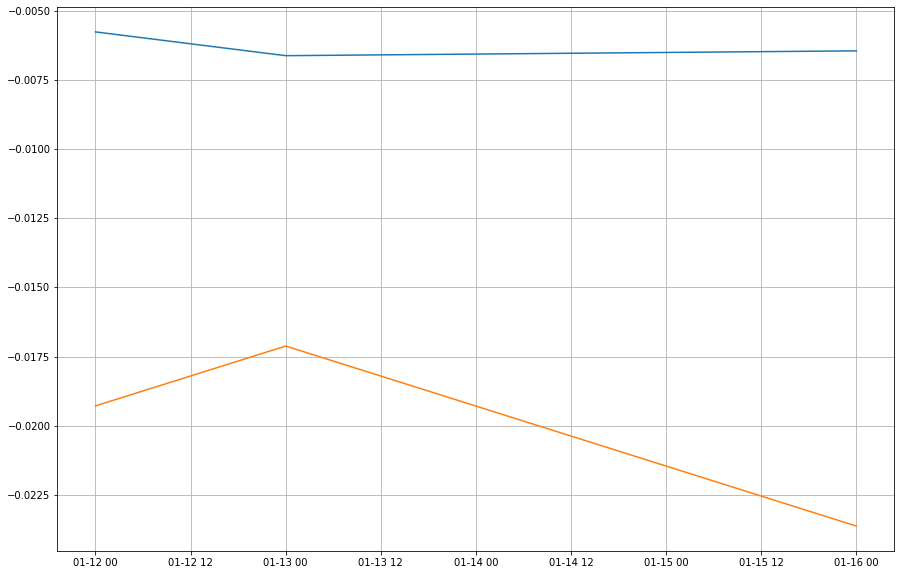

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

ticker = tickers.index('ABG.JO')  # Specify the required stock here 

T = len(time_length_1) + len(time_length_2)
T_end = len(time_length_1) + len(time_length_2) + len(time_length_3)
all_m_lists = []
for i in range(0, (p_j-1)):
    m_list = []
    for t in range(0, len(time_length_3)):
        m = all_ticker_m_lists[t][ticker][i][0]
        m_list.append(m)
    all_m_lists.append(m_list)
data_df = pd.DataFrame(data[tickers[ticker]][T:T_end])
data_df['m 1'] =  all_m_lists[0]
del data_df['ABG.JO']                                    # change ticker her and adjust for different number of sp
data_df['m 2'] = all_m_lists[1]
plt.figure(figsize = (15, 10))
plt.grid(True)
#plt.ylim([0, 0.3])
plt.plot(data_df)

## Phase 2 (Selection of discount factors)
* Discount factors are three: beta, delta_phi and delta_gamma. Beta is the discount factor for learning of the  stochastic observational variance v_t, whereas delta_phi and delta_gamma are for specifying **W**_t using the standard block discounting approach of West and Harrison 1997. The procedure involves varying the values of one discount factor at a time, when the other two are kept constant. Consquently, this phase has three similar (but run separately) codes. The optimal value of a discount factor is one that maximises the log-likelihood function. 

### Selection of the value of delta_phi

In [3]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from scipy.stats import multivariate_t
from math import gamma, pi

df_range = np.linspace(0.99, 0.999, num = 5)                       # interval over which beta is chosen 

LLH_all_t_df_list = []
for delta_phi in df_range:
    
    beta, delta_gamma, time_length_2, M = 0.95, 0.997, range(780, 790), len(tickers)
    
    r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01
    
    r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
    c_list.extend(c_list*(M-1))
    
    a = np.array([[i] for i in a])
    a_list = [a]
    a_list.extend(a_list*(M-1))
    
    R_values.extend([diag_element]*number_of_sp)
    R = np.diag(R_values)
    R_list = [R]
    R_list.extend(R_list*(M-1))
    
    LLH_all_t_list = []
    for t in time_length_2:

        n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists = [], [], [], []
        r_LLH_list, f_LLH_list, q_LLH_list = [], [], []
    
        for ticker in tickers:
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks
            
            a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

            r_LLH_list.append(r) # keep a list of r values to be used to calculate loglikelihood
            
            gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
            tickers.remove(ticker)                          # remove its symbol from the columns       
            F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                      for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
            F_list = [1] + F_list
            F = np.array([ [i] for i in F_list])
            all_stocks.insert(index, ticker)                    # get back full list of stocks    
                
            f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
            f_LLH_list.append(f[0][0])
            q = F.transpose() @ R @ F + c    
            q_LLH_list.append(q[0][0]) 
            e = data[ticker][t] - f 
            A = (R @ F)/q
            z = (r + (e**2)/q)/(r+1)
            m = a +A*e
            C = (R-(A @ A.transpose())*q)*z
            n = r + 1
            n_list.append(n)
            s = z*c; s = s[0][0]
        
            lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
            all_lamda_IS_lists.append(lamda_IS_list)    
                                                   # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
            single_ticker_sp_sets_IS = [] 
            theta_IS_list = []
            for i in range(0, N):
                
                # simulation of state for IS                
                theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
                theta_IS_list.append(theta_IS.reshape(-1, 1))
    
                sp_set_IS = [data[ticker][t] for ticker in tickers]  # returns for all stocks at time t  
                theta_IS = theta_IS_list[i]
                
                for i in range(0, M):
                    for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                        if sp_set_IS[i] == F[k][0]:
                            sp_set_IS[i] = theta_IS[k][0]               
                for i in range(0, M):
                    u = 0
                    for k in range(1, (number_of_sp+1)): 
                        if sp_set_IS[i] == theta_IS[k][0]:
                            u = u + 1
                    if u == 0:
                        sp_set_IS[i] = 0
                single_ticker_sp_sets_IS.append(sp_set_IS)
                            
            all_sp_sets_IS.append(single_ticker_sp_sets_IS)
            all_theta_IS_lists.append(theta_IS_list)
            
        IS_weight_list = []
        for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
            Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
            Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
            IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
            IS_weight_list.append(IS_weight)
        IS_weight_array = np.array(IS_weight_list)
        alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
        
        LLH_t_list = []
        for ticker in tickers: 
            index = tickers.index(ticker)              
            e = data[ticker][t] - f_LLH_list[index]   # get forecast error, degrees of freedom and scale for each stock 
            deg_fre = r_LLH_list[index]
            scale_value = q_LLH_list[index]
            
            # predictive distribution density used to set up loglikelihood 
            part_1 = np.log( gamma((deg_fre+1)/2) / (gamma(deg_fre/2)* (deg_fre*pi*scale_value)**0.5 ) )
            part_2 =  ((deg_fre + 1) /2) * np.log( 1 + (e**2)/(deg_fre*scale_value))
            LLH_t  = part_1 - part_2        # loglikelihood at time t for each stock 
            LLH_t_list.append(LLH_t)
        
        LLH_all_t_list.append(LLH_t_list)
            
        n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
        
                              # VB starts here 
        for ticker in tickers: 
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
            lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
            theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

            m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
            m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
            m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 
            
                         
            V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                     for i in range(0, N) ])   # calculation of V using the VB formula 
           
            d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                    (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d
            
            p_j = len(theta_IS)           # size of state vector in phases 2 and 3 
    
            n_initial = n_list[index]          # calculation of n 
            sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
            sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
            func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                              np.log(abs( 2 * sum_1)) + sum_2)
            n =  fsolve(func, [n_initial])[0]
            n_list_2.append(n)
            
            sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
            s =(n + p_j - d)/(n*sum_in_s) 
    
            C = s*V                     # Calculation of C
            
            a =  m                          # kalman filter equations, evolution to the next day 
            a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
            block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
            block_2 = C[1:, 1:] * (1/delta_gamma-1)
            W  = block_diag(block_1, block_2)

            R = C + W
            R_temp_list.append(R) 
            r = beta*n
            r_temp_list.append(r)
            c = s
            c_temp_list.append(c)
                      
        a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
        R_list = R_temp_list
        r_list = r_temp_list
        c_list = c_temp_list
    LLH_all_t_df_list.append(LLH_all_t_list)

all_LLH = []                       # LLH_all_t_df_list is a list of lists of LLH values of all stocks for
for i in LLH_all_t_df_list:          # different discount factors at different times 
    LLH_each_df = []                
    for ticker in tickers:             # We want to sum up (independently) LLH values for each stock for the
        index = tickers.index(ticker)    #  entire period of time for every discount factor
        LLH_list = [k[index] for k in i]
        LLH = sum(LLH_list)
        LLH_each_df.append(LLH)
    all_LLH.append(LLH_each_df)  # all_LLH is the list with loglikelihood for each stock at different discount factors
df_value_list = []
for ticker in tickers: 
    index = tickers.index(ticker)
    single_stock_LLH_list = [ k[index] for k in all_LLH ]
    df_value = df_range[np.argmax(single_stock_LLH_list)]
    df_value_list.append(df_value)
print('delta_phi values =', df_value_list)
ave_delta_phi =  sum(df_value_list)/M
print('Average value of delta_phi is ', round(ave_delta_phi, 5))

delta_phi values = [0.99, 0.999, 0.99, 0.9944999999999999]
Average value of delta_phi is  0.99338
CPU times: total: 1min 29s
Wall time: 1min 53s


In [96]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from math import gamma, pi                     

df_range = np.linspace(0.88, 0.98, num = 5) # interval over which beta is chosen 

LLH_all_t_df_list = []
for beta in df_range:

    delta_phi, delta_gamma, time_length_2, M = 0.98, 0.96, range(780, 1040), len(tickers)
    
    r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01
    
    r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
    print('r = ', r_list)
    c_list.extend(c_list*(M-1))
    
    a = np.array([[i] for i in a])
    a_list = [a]
    a_list.extend(a_list*(M-1))
    
    R_values.extend([diag_element]*number_of_sp)
    R = np.diag(R_values)
    R_list = [R]
    R_list.extend(R_list*(M-1))
    
    LLH_all_t_list = []
    for t in time_length_2:
        print( " " )

        n_list = []
        all_sp_sets_IS = []
        all_lamda_IS_lists = []
        all_theta_IS_lists = []
        r_LLH_list = []
        f_LLH_list = []
        q_LLH_list = []
    
        for ticker in tickers:
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
            
            a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

            r_LLH_list.append(r) # keep a list of r values to be used to calculate loglikelihood
            
            gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
            tickers.remove(ticker)                          # remove its symbol from the columns       
            F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                      for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
            F_list = [1] + F_list
            F = np.array([ [i] for i in F_list])
            all_stocks.insert(index, ticker)                    # get back full list of stocks   
    
            f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
            f_LLH_list.append(f[0][0])
            q = F.transpose() @ R @ F + c    
            q_LLH_list.append(q[0][0]) 
            e = data[ticker][t] - f 
            A = (R @ F)/q
            z = (r + (e**2)/q)/(r+1)
            m = a +A*e
            C = (R-(A @ A.transpose())*q)*z
            n = r + 1
            n_list.append(n)
            s = z*c; s = s[0][0]
        
            lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
            all_lamda_IS_lists.append(lamda_IS_list)
                                                   # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
            single_ticker_sp_sets_IS = [] 
            theta_IS_list = []
            for i in range(0, N):
                 # simulation of state vector theta given precision lambda                                                                                                                                                                            
                theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
                theta_IS_list.append(theta_IS.reshape(-1, 1))
                
                sp_set_IS = [data[ticker][t] for ticker in tickers]    # returns for all stocks at time t
                theta_IS = theta_IS_list[i]
                
                for i in range(0, M):
                    for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                        if sp_set_IS[i] == F[k][0]:
                            sp_set_IS[i] = theta_IS[k][0]               
                for i in range(0, M):
                    u = 0
                    for k in range(1, (number_of_sp+1)): 
                        if sp_set_IS[i] == theta_IS[k][0]:
                            u = u + 1
                    if u == 0:
                        sp_set_IS[i] = 0
                single_ticker_sp_sets_IS.append(sp_set_IS)
                            
            all_sp_sets_IS.append(single_ticker_sp_sets_IS)
            all_theta_IS_lists.append(theta_IS_list)
        
        IS_weight_list = []
        for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
            Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
            Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
            IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
            IS_weight_list.append(IS_weight)
        IS_weight_array = np.array(IS_weight_list)
        alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
        
        LLH_t_list = []
        for ticker in tickers: 
            index = tickers.index(ticker)              
            e = data[ticker][t] - f_LLH_list[index]   # get forecast error, degrees of freedom and scale for each stock 
            deg_fre = r_LLH_list[index]
            scale_value = q_LLH_list[index]
            
            # predictive distribution density used to set up loglikelihood 
            part_1 = np.log( gamma((deg_fre+1)/2) / (gamma(deg_fre/2)* (deg_fre*pi*scale_value)**0.5 ) )
            part_2 =  ((deg_fre + 1) /2) * np.log( 1 + (e**2)/(deg_fre*scale_value))
            LLH_t  = part_1 - part_2        # loglikelihood at time t for each stock 
            LLH_t_list.append(LLH_t)
        
        LLH_all_t_list.append(LLH_t_list)
            
        n_list_2 = []
        a_temp_list = []
        R_temp_list = []
        r_temp_list = []
        c_temp_list = []
                              # VB starts here 
        for ticker in tickers: 
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
            lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
            theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

            m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
            m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
            m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 
            
                         
            V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                     for i in range(0, N) ])   # calculation of V using the VB formula 
           
            d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                    (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d
            
            p_j = len(theta_IS)           # size of state vector in phases 2 and 3 
                
            n_initial = n_list[index]          # calculation of n 
            sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
            sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
            func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                              np.log(abs( 2 * sum_1)) + sum_2)
            n =  fsolve(func, [n_initial])[0]
            n_list_2.append(n)
            
            sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
            s =(n + p_j - d)/(n*sum_in_s) 
    
            C = s*V                     # Calculation of C
            
            a =  m                          # kalman filter equations, evolution to the next day 
            a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
            block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
            block_2 = C[1:, 1:] * (1/delta_gamma-1)
            W  = block_diag(block_1, block_2)

            R = C + W
            R_temp_list.append(R) 
            r = beta*n
            r_temp_list.append(r)
            c = s
            c_temp_list.append(c)
            
        a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
        R_list = R_temp_list
        r_list = r_temp_list
        c_list = c_temp_list
    LLH_all_t_df_list.append(LLH_all_t_list)

all_LLH = []                       # LLH_all_t_df_list is a list of lists of LLH values of all stocks for
for i in LLH_all_t_df_list:          # different discount factors at different times 
    LLH_each_df = []                
    for ticker in tickers:             # We want to sum up (independently) LLH values for each stock for the
        index = tickers.index(ticker)    #  entire period of time for every discount factor
        LLH_list = [k[index] for k in i]
        LLH = sum(LLH_list)
        LLH_each_df.append(LLH)
    all_LLH.append(LLH_each_df)  # all_LLH is the list with loglikelihood for each stock at different discount factors
df_value_list = []
for ticker in tickers: 
    index = tickers.index(ticker)
    single_stock_LLH_list = [ k[index] for k in all_LLH ]
    df_value = df_range[np.argmax(single_stock_LLH_list)]
    df_value_list.append(df_value)
print('beta values =', df_value_list)
ave_beta =  sum(df_value_list)/M
print('Average value of beta is ', round(ave_beta, 5))

r =  [5, 5, 5, 5]
 
n_1 =  [6, 6, 6, 6]
n_2 =  [6.053682473504723, 5.809333840086796, 6.0491410778809085, 5.981056027521205]
 
n_1 =  [6.327240576684156, 6.112213779276381, 6.323244148535199, 6.26332930421866]
n_2 =  [6.640870226048743, 5.882210960050267, 6.313965621941647, 5.954357392120019]
 
n_1 =  [6.843965798922894, 6.176345644844234, 6.556289747308649, 6.239834505065617]
n_2 =  [6.7533263145854, 5.976318344119226, 6.457674573310777, 5.921524094798863]
 
n_1 =  [6.942927156835152, 6.259160142824919, 6.682753624513484, 6.210941203422999]
n_2 =  [6.896576633955311, 5.940003711452412, 6.566224909306787, 5.898125314813899]
 
n_1 =  [7.068987437880674, 6.2272032660781225, 6.778277920189973, 6.190350277036231]
n_2 =  [7.616724065322189, 5.889077854575009, 6.6488699690466975, 6.061913637572744]
 
n_1 =  [7.702717177483526, 6.182388512026008, 6.8510055727610935, 6.334484001064014]
n_2 =  [7.61147402670403, 5.920486941493787, 6.7897871740356015, 5.971982209494793]
 
n_1 =  [7.6980971434995

n_1 =  [8.756048292705145, 8.652640187815539, 8.312248374158095, 9.324632539127046]
n_2 =  [8.3502690986464, 8.542061021211275, 8.725072691220127, 9.333565226163547]
 
n_1 =  [8.348236806808831, 8.517013698665922, 8.678063968273712, 9.213537399023922]
n_2 =  [9.306105144352747, 8.65026475430617, 9.388565125716909, 9.888727539328336]
 
n_1 =  [9.189372527030418, 8.61223298378943, 9.261937310630879, 9.702080234608935]
n_2 =  [8.910715722334606, 8.831801534530307, 9.520279830314234, 10.208802387855323]
 
n_1 =  [8.841429835654452, 8.77198535038667, 9.377846250676527, 9.983746101312684]
n_2 =  [8.785445221966945, 8.251555899272258, 9.946322116614123, 10.799975626465377]
 
n_1 =  [8.731191795330911, 8.261369191359588, 9.752763462620429, 10.503978551289531]
n_2 =  [8.798801451209656, 8.090538404468194, 10.233297513241967, 9.765729347032593]
 
n_1 =  [8.742945277064496, 8.119673795932012, 10.00530181165293, 9.593841825388681]
n_2 =  [9.451845119217598, 7.095464545357517, 9.995865164988441, 9.

n_2 =  [8.007709622271493, 8.297832361557013, 8.360577266284402, 8.054367098806004]
 
n_1 =  [8.046784467598915, 8.302092478170172, 8.357307994330274, 8.087843046949285]
n_2 =  [8.252374341581767, 7.907680791975377, 8.349961724996566, 7.881477777057127]
 
n_1 =  [8.262089420591956, 7.958759096938332, 8.347966317996978, 7.935700443810272]
n_2 =  [8.454406379296545, 8.549215778077645, 7.981453388886034, 8.059496316306186]
 
n_1 =  [8.43987761378096, 8.523309884708329, 8.02367898221971, 8.092356758349442]
n_2 =  [8.06420811200211, 7.970321952339056, 8.187086026133578, 8.050637147535655]
 
n_1 =  [8.096503138561857, 8.013883318058369, 8.20463570299755, 8.084560689831378]
n_2 =  [8.343120300062267, 7.187347539347184, 8.698398827670525, 8.109786835518083]
 
n_1 =  [8.341945864054797, 7.3248658346255215, 8.654590968350062, 8.136612415255913]
n_2 =  [8.526550629171833, 7.492492542517176, 8.63892602904206, 7.899689508472661]
 
n_1 =  [8.503364553671213, 7.593393437415115, 8.602254905557015, 7.9

n_2 =  [7.5786968782198665, 8.014699437863479, 7.677188808428893, 7.405412151762398]
 
n_1 =  [7.6692532528334825, 8.052935505319862, 7.755926151417426, 7.516762693550911]
n_2 =  [7.361901882551877, 7.83037033066607, 7.586705739222718, 6.921255981681184]
 
n_1 =  [7.478473656645652, 7.8907258909861415, 7.676301050515992, 7.090705263879442]
n_2 =  [7.3149626220735975, 7.532407728142111, 7.736727013456124, 6.822265805657342]
 
n_1 =  [7.437167107424766, 7.6285188007650575, 7.808319771841389, 7.003593908978462]
n_2 =  [7.395393234261647, 8.103107258656744, 7.443256593901298, 6.501267608014354]
 
n_1 =  [7.507946046150249, 8.130734387617935, 7.550065802633142, 6.721115495052631]
n_2 =  [7.642103887088035, 8.27087899519779, 7.147685632763733, 6.5323692882274536]
 
n_1 =  [7.72505142063747, 8.278373515774057, 7.289963356832085, 6.748484973640159]
n_2 =  [7.400861536953969, 8.672483125624836, 6.998062174439124, 6.530537038975702]
 
n_1 =  [7.512758152519493, 8.631785150549856, 7.1582947135064

n_1 =  [9.081581476809758, 9.159870286939098, 7.682384021969444, 8.191065385047498]
n_2 =  [9.019927381217732, 8.934546488790252, 7.2030639509561345, 8.184212457947279]
 
n_1 =  [8.937536095471604, 8.86240091013542, 7.338696276841398, 8.202106962993605]
n_2 =  [9.336966401017271, 8.023935635019564, 7.1455376803755914, 8.48827227833094]
 
n_1 =  [9.2165304328952, 8.061063358817215, 7.28807315873052, 8.469679604931228]
n_2 =  [8.93544587309434, 8.045375246364111, 7.339138120754193, 8.839193211016697]
 
n_1 =  [8.86319236832302, 8.079930216800417, 7.45844154626369, 8.778490025694694]
n_2 =  [9.176657252672745, 8.940815248781494, 7.297436447043409, 8.925840372630203]
 
n_1 =  [9.075458382352016, 8.867917418927714, 7.4217440733982, 8.854739527914578]
n_2 =  [9.180811907559821, 9.163504902258932, 7.5152337935730795, 8.875748552520268]
 
n_1 =  [9.079114478652643, 9.06388431398786, 7.61340573834431, 8.810658726217834]
n_2 =  [9.068678458962433, 9.236833220272127, 7.410234018455166, 8.15170099

n_1 =  [8.765191245197695, 7.499541886482264, 9.996385703243394, 8.444989515603954]
n_2 =  [9.153399984874016, 7.725430810552728, 9.655455182690277, 8.984753966509832]
 
n_1 =  [9.054991986689133, 7.798379113286401, 9.496800560767443, 8.906583490528652]
n_2 =  [9.182990770173433, 8.696385377417672, 9.241132808073926, 8.678971619023299]
 
n_1 =  [9.08103187775262, 8.65281913212755, 9.132196871105055, 8.637495024740502]
n_2 =  [8.880357974218718, 10.43153545417485, 8.889436969524992, 8.214564438255321]
 
n_1 =  [8.814715017312473, 10.179751199673868, 8.822704533181993, 8.228816705664682]
n_2 =  [9.387641838539567, 9.514483166508569, 8.710061039633729, 8.131263378540542]
 
n_1 =  [9.26112481791482, 9.37274518652754, 8.664853714877681, 8.155511773115677]
n_2 =  [8.770493398885849, 9.918803841505198, 9.001460696139175, 7.824975780326297]
 
n_1 =  [8.718034191019548, 9.728547380524574, 8.921285412602472, 7.8859786866871415]
n_2 =  [9.038412970315322, 9.626293838318105, 9.51172555695175, 7.68

n_2 =  [10.660955077724958, 11.310616231557841, 9.910833355786588, 10.198052950982033]
 
n_1 =  [10.648164345341087, 11.236107689559846, 9.969304186986863, 10.22923792063874]
n_2 =  [10.81841155049569, 11.750924585485516, 9.086247106612015, 9.617880055197709]
 
n_1 =  [10.7906624531986, 11.634586749864392, 9.223053631483873, 9.704181449953927]
n_2 =  [10.45060368174476, 12.624398719640958, 8.961145221127744, 9.705542147797715]
 
n_1 =  [10.457796331979008, 12.425080841275067, 9.109836425120609, 9.783515643756932]
n_2 =  [11.133135573556892, 13.667746082488021, 8.792094109563548, 10.135150682691998]
 
n_1 =  [11.075487694068988, 13.36931020465166, 8.956845169155011, 10.172311367836258]
n_2 =  [11.84593215623726, 13.274761461028342, 9.33768527073607, 10.926054543136392]
 
n_1 =  [11.72056860139472, 13.013659122230651, 9.450605170016145, 10.888079361538434]
n_2 =  [12.665346267349104, 12.92338816253328, 9.625164818438385, 10.681875827617334]
 
n_1 =  [12.462138371950939, 12.69566628709262

n_1 =  [13.521271931304865, 12.188865724631889, 9.838307738597647, 10.157006545838682]
n_2 =  [14.184992388474374, 12.570950442198892, 10.301023746204596, 10.387291586770749]
 
n_1 =  [13.837418111569308, 12.376710150189998, 10.32242649031516, 10.400498886027528]
n_2 =  [14.178998768944496, 13.72980591245439, 10.63316126640282, 9.771003333812509]
 
n_1 =  [13.83199388589477, 13.425474350771223, 10.623010946094551, 9.842758017100321]
n_2 =  [14.044115893087271, 13.619757011753784, 11.02836675202886, 10.00159243255858]
 
n_1 =  [13.70992488324398, 13.325880095637174, 10.98067191058612, 10.051441151465514]
n_2 =  [13.82185907939389, 12.446803745835602, 10.93602542861241, 10.772085766763867]
 
n_1 =  [13.508782466851471, 12.264357389981221, 10.897103012894231, 10.7487376189213]
n_2 =  [13.2953182849769, 12.177473343949282, 10.596366474761119, 11.099857574444622]
 
n_1 =  [13.032263047904095, 12.0206133762741, 10.589711659658812, 11.045371104872382]
n_2 =  [12.786785116628108, 10.5991012612

n_2 =  [9.869632392877268, 9.907552634453642, 11.740688934042515, 12.365149852733767]
 
n_1 =  [9.932017315553928, 9.966335134180547, 11.625323485308476, 12.19046061672406]
n_2 =  [9.951518153703955, 10.036473450513151, 11.344025492718169, 11.92126036977125]
 
n_1 =  [10.00612392910208, 10.083008472714402, 11.266343070909944, 11.788740634642982]
n_2 =  [10.301836328545793, 9.575320363357791, 11.457800560925685, 11.398986533619048]
 
n_1 =  [10.323161877333943, 9.665664928838801, 11.369309507637745, 11.31608281292524]
n_2 =  [9.760399945069114, 9.46527642911914, 10.90192745698972, 11.156368068370059]
 
n_1 =  [9.833161950287549, 9.566075168352821, 10.866244348575696, 11.096513101874903]
n_2 =  [10.414887073101196, 9.477332735087508, 10.701430035663392, 10.74335987863636]
 
n_1 =  [10.425472801156584, 9.576986125254194, 10.68479418227537, 10.722740690165907]
n_2 =  [11.13382548898686, 9.733535541133223, 9.9975921829373, 10.417817327100147]
 
n_1 =  [11.076112067533108, 9.808849664725567,

n_1 =  [9.01066816182275, 13.254404660439315, 13.026909013835601, 10.2635972806274]
n_2 =  [9.073011885732068, 12.52206136374022, 12.85323928904844, 10.142775917179229]
 
n_1 =  [9.211075756587523, 12.332465534184898, 12.632181556588838, 10.179212205047202]
n_2 =  [9.269145737708866, 12.400166071563655, 12.996385745067792, 10.216313479871358]
 
n_1 =  [9.388576892626524, 12.222150294765108, 12.761729099286352, 10.245763699283579]
n_2 =  [9.394451192468923, 12.760021187889159, 13.376979765319687, 10.604118764574048]
 
n_1 =  [9.501978329184375, 12.547819175039688, 13.106166687614317, 10.596727481939514]
n_2 =  [9.75632237492884, 13.175475562999813, 12.839778317160464, 10.267714415598482]
 
n_1 =  [9.829471749310601, 12.92380538451483, 12.61999937703022, 10.292281546116627]
n_2 =  [9.698626037687907, 13.19784804976007, 12.728946977901417, 10.489294935829475]
 
n_1 =  [9.777256564107557, 12.944052485032865, 12.519697015000784, 10.492811916925675]
n_2 =  [10.733560766334993, 12.72551944560

n_1 =  [10.580266001587928, 10.475743608797377, 10.52340768468934, 8.885715355899404]
n_2 =  [10.21089297496684, 11.094214175575335, 10.864055751878121, 8.868234445819082]
 
n_1 =  [10.24085814234499, 11.040263828895679, 10.8319704554497, 9.02575217346627]
n_2 =  [10.452805992822402, 11.195669087897263, 11.155016220281485, 9.168727835757611]
 
n_1 =  [10.459789423504274, 11.132080524547023, 11.095289679354744, 9.297698691360639]
n_2 =  [10.636052833032377, 10.703931910070919, 11.424329157388692, 8.949032927706062]
 
n_1 =  [10.625627813894301, 10.687058378614182, 11.339017887436768, 9.098874799573986]
n_2 =  [11.128420902719187, 10.894890061551129, 11.348772896522599, 8.882516267217747]
 
n_1 =  [11.071220916960865, 10.859875505703771, 11.270639471352952, 9.038677221832062]
n_2 =  [12.252985910708743, 10.914036352152785, 10.900435872338704, 8.989532505362217]
 
n_1 =  [12.088952249191413, 10.87720289869827, 10.864894464466527, 9.135526917352806]
n_2 =  [11.771181837173149, 10.706781297

n_2 =  [10.201940883276711, 10.730925724392286, 11.321461349581945, 10.504853826838078]
 
n_1 =  [10.48780502144734, 10.979760923684825, 11.528959055111208, 10.769514058959412]
n_2 =  [11.55473077817689, 11.310612069379173, 11.345144982187696, 11.199331287276701]
 
n_1 =  [11.745899623704506, 11.51886922452263, 11.550984833434557, 11.41537809716733]
n_2 =  [12.718894325063944, 10.853987305096464, 10.72619083240773, 11.049998651135597]
 
n_1 =  [12.828571722309468, 11.09420819373971, 10.975357474139187, 11.276498745556104]
n_2 =  [12.252681539937713, 11.916973831035598, 11.534815291611809, 11.315483609911897]
 
n_1 =  [12.394993832142072, 12.082785662863106, 11.72737822119898, 11.523399757218064]
n_2 =  [13.024625087036751, 12.494863568031187, 11.195024419589695, 11.512355151830727]
 
n_1 =  [13.112901330944178, 12.620223118269003, 11.411372710218416, 11.706490291202575]
n_2 =  [13.878882660529738, 13.402007708178461, 11.443723388978729, 11.267633061947622]
 
n_1 =  [13.907360874292657,

n_2 =  [15.429593117394715, 16.856059323921805, 14.390045450981614, 14.513956433989]
 
n_1 =  [15.349521599177084, 16.676135171247278, 14.3827422694129, 14.497979483609768]
n_2 =  [15.472477140713185, 17.107086824614065, 13.553186821621917, 13.962878817537488]
 
n_1 =  [15.38940374086326, 16.909590746891077, 13.604463744108383, 13.985477300309864]
n_2 =  [15.618324581500497, 17.390259156797143, 13.082375411473903, 13.25526564249763]
 
n_1 =  [15.525041860795461, 17.17294101582134, 13.166609132670729, 13.327397047522794]
n_2 =  [15.845101523286298, 15.92930410900182, 12.757155764594293, 13.992211822180801]
 
n_1 =  [15.735944416656256, 15.81425282137169, 12.864154861072691, 14.012756994628145]
n_2 =  [15.743329185869708, 14.72405522151619, 12.891932001912672, 15.271042060997939]
 
n_1 =  [15.641296142858828, 14.693371356010056, 12.989496761778783, 15.202069116728081]
n_2 =  [15.247619439439164, 14.917106211887864, 12.650751702082962, 16.38480759047588]
 
n_1 =  [15.180286078678423, 14.8

n_2 =  [14.04925240525797, 14.88820109306946, 15.677377286518045, 13.642037369132732]
 
n_1 =  [14.06580473688991, 14.846027016554597, 15.579960876461781, 13.68709475329344]
n_2 =  [13.697547130745493, 13.848056653206273, 16.410717977608236, 13.803695534708165]
 
n_1 =  [13.738718831593307, 13.878692687481832, 16.261967719175658, 13.837436847278592]
n_2 =  [13.909545139014769, 14.505686101484711, 15.393944381338056, 14.090965941333783]
 
n_1 =  [13.935876979283734, 14.49028807438078, 15.316368274644391, 14.104598325440417]
n_2 =  [15.534668953758779, 13.324329421514577, 16.086347508064712, 14.183379136604259]
 
n_1 =  [15.447242126995663, 13.391626362008555, 15.960303182500182, 14.19054259704196]
n_2 =  [15.67482453953728, 12.98702163106573, 16.854516956303318, 12.974299438339317]
 
n_1 =  [15.57758682176967, 13.077930116891128, 16.674700769362083, 13.066098477655563]
n_2 =  [14.46268980365742, 13.656745013256124, 17.486052812169007, 13.066636174672926]
 
n_1 =  [14.4503015174014, 13.7

n_2 =  [16.65130831608212, 14.446280668936883, 15.92626167989266, 13.355320026552493]
 
n_1 =  [16.48571673395637, 14.4350410221113, 15.811423362300173, 13.420447624693818]
n_2 =  [17.545426822544222, 14.511049626278822, 14.766600837248392, 14.491636569927831]
 
n_1 =  [17.317246944966126, 14.495276152439304, 14.732938778641003, 14.477222010032882]
n_2 =  [17.111253026050747, 14.274220042281316, 13.992484084937107, 14.55228188319544]
 
n_1 =  [16.913465314227196, 14.275024639321623, 14.013010198991509, 14.533622151371757]
n_2 =  [17.46958523879857, 14.253162001263403, 14.320704394602105, 14.38190479624335]
 
n_1 =  [17.246714272082666, 14.255440661174964, 14.318255086979956, 14.375171460506316]
n_2 =  [18.454664127672984, 13.889005975174582, 14.542106808544398, 13.586779668925717]
 
n_1 =  [18.162837638735873, 13.916775556912361, 14.52415933194629, 13.635705092100915]
n_2 =  [17.44807301573129, 14.732527725687076, 13.03889877735398, 14.315012002257061]
 
n_1 =  [17.226707904630096, 14.

n_1 =  [14.40535831362022, 14.59048115635845, 12.33749484232724, 13.709148216672727]
n_2 =  [14.398992985153528, 14.6057838353944, 13.051804556317938, 13.423698418596414]
 
n_1 =  [14.39106347619278, 14.58337896691679, 13.138178237375682, 13.484039529294664]
n_2 =  [12.76781529652323, 13.969039245834622, 12.226005877192378, 12.984712024809706]
 
n_1 =  [12.874068225766603, 13.991206498626198, 12.37018546578891, 13.075782183073025]
n_2 =  [12.841336742126838, 14.505470510577588, 12.622827532944033, 13.553171363721688]
 
n_1 =  [12.94244317017796, 14.490087574837156, 12.73922960563795, 13.60444936826117]
n_2 =  [14.022060657577306, 14.968254350854544, 13.58879884754893, 13.524016672842318]
 
n_1 =  [14.040516411546895, 14.920476546294724, 13.637582928220503, 13.577335505743354]
n_2 =  [13.743650438424684, 15.328545735877125, 14.195686620809134, 12.846654952666679]
 
n_1 =  [13.781594907734956, 15.255547534365725, 14.201988557352493, 12.94738910598001]
n_2 =  [13.601297063552053, 15.78224

n_1 =  [16.625182844131476, 11.003296439471955, 17.53858202250139, 14.72511593597771]
n_2 =  [16.931307448891207, 10.6137036632907, 18.36000372517753, 13.896805054045547]
 
n_1 =  [16.74611592746882, 10.87074440686035, 18.0748034644151, 13.924028700262358]
n_2 =  [17.41679140980049, 10.556103219142372, 16.824113882793263, 14.238235622747208]
 
n_1 =  [17.19761601111445, 10.817175993802405, 16.646425910997735, 14.241559129154902]
n_2 =  [16.946751903035974, 10.426619762304052, 17.725396351369074, 13.379807886188013]
 
n_1 =  [16.760479269823456, 10.696756378942768, 17.48461860677324, 13.44322133415485]
n_2 =  [16.939365311350933, 10.844491000406979, 16.44174023957586, 13.706675928877138]
 
n_1 =  [16.753609739556367, 11.085376630378489, 16.29081842280555, 13.747208613855737]
n_2 =  [17.169440207674448, 11.008381618337419, 16.508746593727654, 13.411652418476175]
 
n_1 =  [16.967579393137235, 11.237794905053798, 16.353134332166718, 13.472836749182841]
n_2 =  [17.904353623500757, 11.331453

n_2 =  [16.645292357794876, 20.327186843098634, 17.331628945640933, 22.118111264428073]
 
n_1 =  [16.896254201694106, 20.412463435159193, 17.55170564308709, 22.122796257528808]
n_2 =  [16.670946549437048, 19.427455079453587, 16.21139024175554, 22.210331094067204]
 
n_1 =  [16.92075395471238, 19.553219600878176, 16.481877680876543, 22.21086619483418]
n_2 =  [17.548631602100617, 19.896847524373214, 15.947687353177137, 23.458166183244547]
 
n_1 =  [17.75894318000609, 20.00148938577642, 16.230041422284167, 23.40254870499854]
n_2 =  [18.663883610964273, 20.502151169663506, 15.739063381466513, 22.574207528107138]
 
n_1 =  [18.82400884847088, 20.579554367028646, 16.03080552930052, 22.558368189342318]
n_2 =  [20.90192021913751, 20.8437424560963, 15.870356005391901, 22.822926288524066]
 
n_1 =  [20.96133380927632, 20.905774045571967, 16.156189985149265, 22.795894605540482]
n_2 =  [22.073840501939507, 22.138162899869535, 15.778673381830124, 22.886053142377328]
 
n_1 =  [22.08051767935223, 22.141

n_2 =  [23.229915733843796, 29.485058680517106, 23.621460413135345, 20.18382683760704]
 
n_1 =  [23.184569525820823, 29.158231039893835, 23.558494694544255, 20.275554629914723]
n_2 =  [25.001230045696083, 28.83864781711713, 25.596018810601695, 20.409905837040576]
 
n_1 =  [24.876174693639758, 28.54090866534686, 25.44419796412462, 20.491460074373748]
n_2 =  [26.471237031093874, 28.23905282820194, 24.379786557247176, 20.149365871943314]
 
n_1 =  [26.28003136469465, 27.968295450932853, 24.282696162171053, 20.242644407705864]
n_2 =  [24.23452726341684, 27.158033348736577, 23.94878169997577, 20.114729791482972]
 
n_1 =  [24.14397353656308, 26.93592184804343, 23.87108652347686, 20.209566950866236]
n_2 =  [23.183609673732967, 25.36557201696228, 22.88629866027578, 20.419813493042355]
 
n_1 =  [23.140347238414982, 25.224121276198975, 22.85641522056337, 20.500921885855448]
n_2 =  [24.007880747699655, 25.189534440588766, 22.393773779089365, 20.446615578124938]
 
n_1 =  [23.92752611405317, 25.0560

n_2 =  [27.469791898837105, 22.732449601356517, 19.838044373321413, 23.923740242790767]
 
n_1 =  [27.233651263389433, 22.709489369295472, 19.94533237652195, 23.847171931865184]
n_2 =  [28.42996415222147, 23.59660510841418, 18.519653940622028, 24.069063677919775]
 
n_1 =  [28.1506157653715, 23.53475787853554, 18.686269513294036, 23.985955812413383]
n_2 =  [27.12216683273819, 23.289877182567036, 19.436747778990203, 23.954721708504422]
 
n_1 =  [26.901669325264972, 23.241832709351517, 19.56209412893564, 23.876759231621723]
n_2 =  [27.869710235647943, 22.146942796671265, 19.84867661430109, 23.66942853497294]
 
n_1 =  [27.615573275043786, 22.150330370821056, 19.95548616665754, 23.60430425089916]
n_2 =  [28.45859563149553, 21.66779532139832, 20.377426114938675, 23.479220167930507]
 
n_1 =  [28.177958828078232, 21.692744531935393, 20.460441939766433, 23.422655260373634]
n_2 =  [28.54347728058482, 21.906193402631327, 20.24808187237654, 22.53129390912355]
 
n_1 =  [28.259020802958503, 21.920414

n_1 =  [22.61334064743425, 34.217109610109176, 24.251809726247426, 23.873876081457194]
n_2 =  [23.3726593888463, 32.48589939670545, 25.980107113933826, 24.600434003000856]
 
n_1 =  [23.320889716348216, 32.02403392385371, 25.8110022938068, 24.493414472865815]
n_2 =  [24.293697006763583, 29.938713644243755, 26.061026804543307, 24.413589776483285]
 
n_1 =  [24.200480641459222, 29.591471530252786, 25.888280598338856, 24.314978236541535]
n_2 =  [22.976235200638754, 30.956306105077427, 25.92153186946132, 23.29161150846476]
 
n_1 =  [22.94230461661001, 30.56327233034894, 25.75506293533556, 23.243488990583845]
n_2 =  [21.572526726127215, 26.953159430891056, 25.243802874181057, 23.543695328321792]
 
n_1 =  [21.60176302345149, 26.740267256500957, 25.10783174484291, 23.484229038547312]
n_2 =  [22.48953345016509, 25.529666341249996, 23.965772546888168, 25.68135358325854]
 
n_1 =  [22.477504444907662, 25.380831355893744, 23.8873127822782, 25.525692672011907]
n_2 =  [22.534928966305433, 25.591439313

n_1 =  [18.376280404569428, 27.285387664135126, 23.206029751413887, 22.674600153472284]
n_2 =  [18.385389918266124, 26.14563696734687, 23.403878250953763, 21.533990343436734]
 
n_1 =  [18.55804737194415, 25.96908330381626, 23.350703729660843, 21.56496077798208]
n_2 =  [18.182077680640454, 26.532393683583102, 23.444625155944568, 21.543481303349413]
 
n_1 =  [18.36388418501163, 26.338435967821862, 23.389617023927062, 21.57402464469869]
n_2 =  [19.242718818771024, 25.506380653541783, 22.964854271027818, 22.188662727465744]
 
n_1 =  [19.376796471926326, 25.358593524132402, 22.931435828831564, 22.190172904729785]
n_2 =  [19.441380980313625, 25.941816262445634, 22.10116408407697, 21.71129950618659]
 
n_1 =  [19.56651883619951, 25.77443453063558, 22.106611700293506, 21.734291028408194]
n_2 =  [18.452450134415617, 24.945421147145467, 23.625328710455786, 21.083574158089718]
 
n_1 =  [18.622089878366914, 24.82287719552392, 23.562188918485276, 21.13481332097568]
n_2 =  [18.61486586642183, 26.5708

n_2 =  [12.725114367016008, 13.109532310923493, 13.382320822609225, 13.2690182412742]
 
n_1 =  [13.470612079675687, 13.847341664705024, 14.114674406157041, 14.003637876448716]
n_2 =  [13.907018292513182, 14.573305020781936, 13.897473972540494, 13.679162832277694]
 
n_1 =  [14.628877926662918, 15.281838920366297, 14.619524493089685, 14.405579575632139]
n_2 =  [14.201545869977778, 14.800671097853117, 15.255093419434289, 14.087973685727247]
 
n_1 =  [14.917514952578223, 15.504657675896054, 15.949991551045603, 14.806214212012701]
n_2 =  [17.006702841752343, 15.959553983736631, 15.590826141240433, 15.250331291742457]
 
n_1 =  [17.666568784917295, 16.6403629040619, 16.27900961841562, 15.945324665907608]
n_2 =  [18.181391235008178, 17.74318062483637, 17.136770915635104, 16.888552564821534]
 
n_1 =  [18.817763410308014, 18.38831701233964, 17.7940354973224, 17.550781513525102]
n_2 =  [19.59602772563337, 18.916705580035018, 17.588987508720074, 16.861561899298025]
 
n_1 =  [20.2041071711207, 19.5

n_2 =  [27.72993443734234, 31.51350448466719, 53.88283652047947, 38.14630233360118]
 
n_1 =  [28.175335748595494, 31.883234394973847, 53.80517979006988, 38.383376286929156]
n_2 =  [28.586999253272307, 32.83022790922649, 53.01311461934451, 39.02001185511377]
 
n_1 =  [29.01525926820686, 33.173623351041954, 52.952852326957625, 39.239611618011494]
n_2 =  [29.375087156566277, 33.623799088002954, 52.118983729828216, 40.79769445427491]
 
n_1 =  [29.78758541343495, 33.951323106242896, 52.07660405523165, 40.98174056518941]
n_2 =  [29.223675464999015, 34.194339548793714, 50.31491706717771, 43.92886775900897]
 
n_1 =  [29.639201955699036, 34.51045275781784, 50.30861872583416, 44.0502904038288]
n_2 =  [29.873394707902943, 34.86340696362515, 50.756581221385986, 46.63741258429256]
 
n_1 =  [30.275926813744885, 35.16613882435265, 50.74144959695826, 46.70466433260671]
n_2 =  [29.01297732486594, 34.696211036287785, 51.53257917367414, 44.93385097835562]
 
n_1 =  [29.43271777836862, 35.00228681556203, 5

n_2 =  [34.64726615347965, 48.89231916233693, 55.86089014205572, 42.583817381379504]
 
n_1 =  [34.954320830410055, 48.91447277909019, 55.743672339214605, 42.732141033751915]
n_2 =  [34.61296848647187, 46.7279505835195, 54.74775282711654, 42.556468474512116]
 
n_1 =  [34.92070911674244, 46.793391571849114, 54.65279777057421, 42.70533910502187]
n_2 =  [35.069199418569106, 44.37052813762154, 52.850929114866005, 43.00885698336843]
 
n_1 =  [35.36781543019772, 44.48311757486911, 52.79391053256868, 43.14867984370106]
n_2 =  [35.011242610424844, 42.83992095101223, 53.22539413330862, 43.28690239535678]
 
n_1 =  [35.311017758216344, 42.98312253199199, 53.16088625064245, 43.42116434744965]
n_2 =  [37.11539994520128, 45.15403879796953, 52.61464042341686, 44.22284245057902]
 
n_1 =  [37.37309194629726, 45.25095802201014, 52.56234761494852, 44.33838560156744]
n_2 =  [39.35875596196558, 43.64881074236818, 49.4780521941609, 44.866461539059216]
 
n_1 =  [39.57158084272626, 43.775834527520814, 49.48849

n_2 =  [54.32942528293058, 50.52780548630691, 63.144720850500974, 49.82531209279995]
 
n_1 =  [54.24283677727197, 50.51724937658077, 62.88182643349095, 49.82880585094395]
n_2 =  [53.16320190293937, 48.51832998569552, 66.40267706096803, 54.872537474410386]
 
n_1 =  [53.09993786488058, 48.54796338598161, 66.07462351974867, 54.775086724922176]
n_2 =  [51.46391598304029, 49.372854956111865, 64.9286386606729, 52.78866090623238]
 
n_1 =  [51.43463766337948, 49.38539785698963, 64.63006588745944, 52.73288768810773]
n_2 =  [52.604962041591186, 48.53034733745471, 58.9725935536175, 56.54148674923817]
 
n_1 =  [52.552862800759364, 48.55974039070561, 58.79314168254515, 56.4106570142534]
n_2 =  [55.064677293842074, 48.71435083211989, 57.815952601931826, 53.71929518745738]
 
n_1 =  [54.96338374796523, 48.74006381547749, 57.65963354989319, 53.64490928370823]
n_2 =  [52.73099907500747, 47.65781658241488, 63.868633510249126, 52.41117882178056]
 
n_1 =  [52.676379093507315, 47.70466025076658, 63.59126084

n_2 =  [44.90673085846923, 70.22821359671201, 59.06479680176261, 55.556982266437274]
 
n_1 =  [45.00859624129985, 69.82364932477776, 58.883500865727356, 55.445842621108525]
n_2 =  [43.95280184006747, 66.65652601825771, 60.050622120463075, 53.130205604440995]
 
n_1 =  [44.07374580326612, 66.32339549789255, 59.84960967805381, 53.067601492352175]
n_2 =  [42.90057648271983, 74.08512682920758, 60.016935079834376, 54.80569926679713]
 
n_1 =  [43.04256495306543, 73.60342429262343, 59.81659637823769, 54.70958528146118]
n_2 =  [41.82785643874663, 74.76441722763597, 63.37304317646669, 57.40143670557423]
 
n_1 =  [41.991299309971694, 74.26912888308325, 63.10558231293735, 57.25340797146274]
n_2 =  [43.08987027707044, 81.10496744530273, 62.45076019920279, 55.599415225901474]
 
n_1 =  [43.22807287152903, 80.48286809639667, 62.20174499521873, 55.487426921383445]
n_2 =  [43.414284409768904, 83.09638664252192, 64.37604835500255, 53.618459563943766]
 
n_1 =  [43.545998721573525, 82.43445890967148, 64.08

n_1 =  [69.00230801798449, 79.79419476649385, 60.89484447957086, 47.76286637603439]
n_2 =  [73.21460643328517, 80.03166147365343, 63.161115761835916, 47.377111931039394]
 
n_1 =  [72.75031430461947, 79.43102824418035, 62.8978934465992, 47.4295696924186]
n_2 =  [76.40177236142041, 76.56708479609355, 64.48259631019397, 46.10307547460167]
 
n_1 =  [75.87373691419201, 76.03574310017169, 64.1929443839901, 46.181013965109635]
n_2 =  [70.83404003914463, 75.83164683274005, 64.04484671403885, 44.54296192381687]
 
n_1 =  [70.41735923836173, 75.31501389608525, 63.76394977975808, 44.65210268534053]
n_2 =  [68.6149039347034, 70.98344731600073, 64.63355162673442, 46.253459283192406]
 
n_1 =  [68.24260585600933, 70.56377836968072, 64.34088059419972, 46.328390097528555]
n_2 =  [71.41867690401058, 66.03181761291198, 61.99247634149005, 48.135383920644664]
 
n_1 =  [70.99030336593037, 65.71118126065373, 61.752626814660246, 48.172676242231766]
n_2 =  [69.73312656274823, 65.24076412435437, 61.1176591900904

In [97]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from math import gamma, pi                     

df_range = np.linspace(0.88, 0.98, num = 5) # interval over which beta is chosen 

LLH_all_t_df_list = []
for beta in df_range:

    delta_phi, delta_gamma, time_length_2, M = 0.98, 0.96, range(780, 1040), len(tickers)
    
    r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01
    
    r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
    print('r = ', r_list)
    c_list.extend(c_list*(M-1))
    
    a = np.array([[i] for i in a])
    a_list = [a]
    a_list.extend(a_list*(M-1))
    
    R_values.extend([diag_element]*number_of_sp)
    R = np.diag(R_values)
    R_list = [R]
    R_list.extend(R_list*(M-1))
    
    LLH_all_t_list = []
    for t in time_length_2:
        print( " " )

        n_list = []
        all_sp_sets_IS = []
        all_lamda_IS_lists = []
        all_theta_IS_lists = []
        r_LLH_list = []
        f_LLH_list = []
        q_LLH_list = []
    
        for ticker in tickers:
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
            
            a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

            r_LLH_list.append(r) # keep a list of r values to be used to calculate loglikelihood
            
            gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
            tickers.remove(ticker)                          # remove its symbol from the columns       
            F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                      for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
            F_list = [1] + F_list
            F = np.array([ [i] for i in F_list])
            all_stocks.insert(index, ticker)                    # get back full list of stocks   
    
            f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
            f_LLH_list.append(f[0][0])
            q = F.transpose() @ R @ F + c    
            q_LLH_list.append(q[0][0]) 
            e = data[ticker][t] - f 
            A = (R @ F)/q
            z = (r + (e**2)/q)/(r+1)
            m = a +A*e
            C = (R-(A @ A.transpose())*q)*z
            n = r + 1
            n_list.append(n)
            s = z*c; s = s[0][0]
        
            lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
            all_lamda_IS_lists.append(lamda_IS_list)
                                                   # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
            single_ticker_sp_sets_IS = [] 
            theta_IS_list = []
            for i in range(0, N):
                 # simulation of state vector theta given precision lambda                                                                                                                                                                            
                theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
                theta_IS_list.append(theta_IS.reshape(-1, 1))
                
                sp_set_IS = [data[ticker][t] for ticker in tickers]    # returns for all stocks at time t
                theta_IS = theta_IS_list[i]
                
                for i in range(0, M):
                    for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                        if sp_set_IS[i] == F[k][0]:
                            sp_set_IS[i] = theta_IS[k][0]               
                for i in range(0, M):
                    u = 0
                    for k in range(1, (number_of_sp+1)): 
                        if sp_set_IS[i] == theta_IS[k][0]:
                            u = u + 1
                    if u == 0:
                        sp_set_IS[i] = 0
                single_ticker_sp_sets_IS.append(sp_set_IS)
                            
            all_sp_sets_IS.append(single_ticker_sp_sets_IS)
            all_theta_IS_lists.append(theta_IS_list)
            
        print('n_1 = ', n_list)
        IS_weight_list = []
        for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
            Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
            Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
            IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
            IS_weight_list.append(IS_weight)
        IS_weight_array = np.array(IS_weight_list)
        alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
        
        LLH_t_list = []
        for ticker in tickers: 
            index = tickers.index(ticker)              
            e = data[ticker][t] - f_LLH_list[index]   # get forecast error, degrees of freedom and scale for each stock 
            deg_fre = r_LLH_list[index]
            scale_value = q_LLH_list[index]
            
            # predictive distribution density used to set up loglikelihood 
            part_1 = np.log( gamma((deg_fre+1)/2) / (gamma(deg_fre/2)* (deg_fre*pi*scale_value)**0.5 ) )
            part_2 =  ((deg_fre + 1) /2) * np.log( 1 + (e**2)/(deg_fre*scale_value))
            LLH_t  = part_1 - part_2        # loglikelihood at time t for each stock 
            LLH_t_list.append(LLH_t)
        
        LLH_all_t_list.append(LLH_t_list)
            
        n_list_2 = []
        a_temp_list = []
        R_temp_list = []
        r_temp_list = []
        c_temp_list = []
                              # VB starts here 
        for ticker in tickers: 
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
            lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
            theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

            m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
            m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
            m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 
            
                         
            V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                     for i in range(0, N) ])   # calculation of V using the VB formula 
           
            d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                    (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d
            
            p_j = len(theta_IS)           # size of state vector in phases 2 and 3 
            
            
            sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
            sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
            n = n_list[index]  
            n_initial = n_list[index]  
            for h in range(0, 5):
                func = (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n - np.log(abs( 2 * sum_1)) + sum_2)
                deriv_func = 1/(n + p_j - d) - 0.5 * special.polygamma(1, (n/2)) + (p_j - d)/n**2
                Delta = func/deriv_func 
                if Delta > n/2:
                    Delta =  n/2
                n = n - Delta
            if n > 2 * n_initial:
                print("Optimisation did not converge")
                n = n_initial
            n_list_2.append(n)
        
            sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
            s =(n + p_j - d)/(n*sum_in_s) 
    
            C = s*V                     # Calculation of C
            
            a =  m                          # kalman filter equations, evolution to the next day 
            a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
            block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
            block_2 = C[1:, 1:] * (1/delta_gamma-1)
            W  = block_diag(block_1, block_2)

            R = C + W
            R_temp_list.append(R) 
            r = beta*n
            r_temp_list.append(r)
            c = s
            c_temp_list.append(c)
            
        print('n_2 = ', n_list_2)
        a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
        R_list = R_temp_list
        r_list = r_temp_list
        c_list = c_temp_list
    LLH_all_t_df_list.append(LLH_all_t_list)

all_LLH = []                       # LLH_all_t_df_list is a list of lists of LLH values of all stocks for
for i in LLH_all_t_df_list:          # different discount factors at different times 
    LLH_each_df = []                
    for ticker in tickers:             # We want to sum up (independently) LLH values for each stock for the
        index = tickers.index(ticker)    #  entire period of time for every discount factor
        LLH_list = [k[index] for k in i]
        LLH = sum(LLH_list)
        LLH_each_df.append(LLH)
    all_LLH.append(LLH_each_df)  # all_LLH is the list with loglikelihood for each stock at different discount factors
df_value_list = []
for ticker in tickers: 
    index = tickers.index(ticker)
    single_stock_LLH_list = [ k[index] for k in all_LLH ]
    df_value = df_range[np.argmax(single_stock_LLH_list)]
    df_value_list.append(df_value)
print('beta values =', df_value_list)
ave_beta =  sum(df_value_list)/M
print('Average value of beta is ', round(ave_beta, 5))

r =  [5, 5, 5, 5]
 
n_1 =  [6, 6, 6, 6]
n_2 =  [6.220016984920288, 6.107036610607996, 6.014468697085911, 6.303761948169698]
 
n_1 =  [6.473614946729853, 6.374192217335037, 6.292732453435601, 6.547310514389334]
n_2 =  [6.502793283081758, 6.861968517660143, 6.723587577566954, 6.884540140817267]
 
n_1 =  [6.722458089111947, 7.038532295540926, 6.916757068258919, 7.0583953239191946]
n_2 =  [6.8447088110659875, 6.96115656392752, 6.942847181287492, 7.306606134439571]
 
n_1 =  [7.023343753738069, 7.125817776256217, 7.1097055195329935, 7.429813398306822]
n_2 =  [7.186704144900817, 6.909929109743829, 6.666023559965965, 7.829398399077127]
 
n_1 =  [7.324299647512719, 7.080737616574569, 6.866100732770049, 7.889870591187872]
n_2 =  [7.203168147268424, 6.5523831418824035, 6.773668961902976, 8.22411010911147]
 
n_1 =  [7.338787969596213, 6.766097164856515, 6.960828686474619, 8.237216896018094]
n_2 =  [7.020103684489129, 6.902625650351921, 7.122342930501796, 7.658137030815576]
 
n_1 =  [7.177691242350

n_1 =  [8.564607714123373, 8.442931243873524, 9.0191807630201, 8.25317244936026]
n_2 =  [8.013806341294213, 8.099802048872757, 8.724253011256781, 8.032380588657615]
 
n_1 =  [8.052149580338908, 8.127825803008026, 8.677342649905967, 8.0684949180187]
n_2 =  [8.483182041254922, 8.277931624411194, 8.374602424355277, 8.184004905125217]
 
n_1 =  [8.46520019630433, 8.28457982948185, 8.369650133432645, 8.20192431651019]
n_2 =  [8.493574740485656, 7.800813581799777, 8.31547744666418, 8.68962375232103]
 
n_1 =  [8.474345771627377, 7.864715951983804, 8.317620153064478, 8.646868902042506]
n_2 =  [8.539684172991064, 7.492961000019538, 7.9761103318743265, 8.71557976448756]
 
n_1 =  [8.514922072232137, 7.593805680017193, 8.018977092049408, 8.669710192749053]
n_2 =  [9.218305769444578, 8.100766518654416, 7.728822620478028, 8.657945602221206]
 
n_1 =  [9.11210907711123, 8.128674536415886, 7.801363906020665, 8.618992129954663]
n_2 =  [8.39259666101056, 7.830698529111892, 6.967706781194058, 8.49481235441

n_2 =  [10.737250623148203, 8.993857587714789, 7.947839075145806, 9.22497381971689]
 
n_1 =  [10.448780548370419, 8.914594677189015, 7.994098386128309, 9.117976961350864]
n_2 =  [11.13075543888434, 9.009503952312322, 7.91413475346329, 9.849356169539412]
 
n_1 =  [10.79506478621822, 8.928363478034843, 7.964438583047695, 9.667433429194682]
n_2 =  [11.180968898408109, 9.489479267508573, 8.571660907645644, 10.272086865760249]
 
n_1 =  [10.839252630599136, 9.350741755407544, 8.543061598728166, 10.03943644186902]
n_2 =  [10.89976654434553, 10.021173762545336, 7.9772793796646875, 9.6983670542991]
 
n_1 =  [10.591794559024066, 9.818632911039897, 8.020005854104925, 9.534563007783207]
n_2 =  [9.817994270589296, 8.589978040589806, 8.00463095729226, 9.979112223148913]
 
n_1 =  [9.63983495811858, 8.559180675719029, 8.04407524241719, 9.781618756371044]
n_2 =  [10.140606521420406, 8.47326364395449, 7.928601965914775, 10.097309817583458]
 
n_1 =  [9.923733738849958, 8.456472006679952, 7.97716973000500

n_1 =  [9.637411973470346, 9.29405056378796, 8.62552286090555, 8.95753540825155]
n_2 =  [8.927225162594306, 8.848614659745033, 8.757395600684982, 8.67246667592542]
 
n_1 =  [8.85595814308299, 8.786780900575629, 8.706508128602785, 8.63177067481437]
n_2 =  [8.626755840906288, 9.108241167158816, 8.009454387601266, 8.24475943923466]
 
n_1 =  [8.591545139997534, 9.015252227099758, 8.048319861089116, 8.2553883065265]
n_2 =  [8.853219310247878, 9.045992110378476, 8.259052304586074, 8.530454485609523]
 
n_1 =  [8.790832993018132, 8.960473057133058, 8.267966028035746, 8.50679994733638]
n_2 =  [8.735167707081962, 9.132878478851472, 7.764944387866483, 8.077327712329177]
 
n_1 =  [8.686947582232126, 9.036933061389295, 7.833151061322505, 8.108048386849676]
n_2 =  [8.804702238409854, 8.854339379862145, 7.804685475366513, 8.264514725568247]
 
n_1 =  [8.748137969800672, 8.791818654278687, 7.868123218322531, 8.272772958500058]
n_2 =  [8.861306485842555, 9.149907154771675, 8.017419364021432, 8.687232814

n_1 =  [7.463562816244979, 8.39530888396078, 8.286644443855522, 8.157432443370688]
n_2 =  [7.29451050955679, 8.122971090030378, 8.73455405895783, 8.673958745852905]
 
n_1 =  [7.419169248409975, 8.148214559226732, 8.68640757188289, 8.633083696350557]
n_2 =  [6.874297713182119, 8.761546431273452, 8.257724025343462, 8.251952289804288]
 
n_1 =  [7.049381987600265, 8.710160859520638, 8.266797142302247, 8.261718015027775]
n_2 =  [6.419021534046026, 9.089206058408482, 8.341594028559854, 7.680185614337091]
 
n_1 =  [6.648738949960503, 8.998501331399464, 8.34060274513267, 7.75856334061664]
n_2 =  [6.663871473636971, 9.564936493755983, 8.639019738334936, 7.877319081711298]
 
n_1 =  [6.8642068968005345, 9.417144114505264, 8.602337369734744, 7.932040791905942]
n_2 =  [6.665625627348727, 9.250317028995873, 8.13782235479587, 8.151688560861793]
 
n_1 =  [6.86575055206688, 9.14027898551637, 8.161283672220367, 8.173485933558378]
n_2 =  [6.433834105006606, 9.454102906448375, 7.413022757714678, 8.2247473

n_2 =  [7.828240938981902, 9.590055348986123, 8.666503732012526, 8.978738378184602]
 
n_1 =  [7.888852026304074, 9.439248707107788, 8.626523284171022, 8.90128977280245]
n_2 =  [8.214931504556608, 9.868524693287759, 8.518410131453985, 8.423936545431937]
 
n_1 =  [8.229139724009816, 9.684301730093228, 8.496200915679506, 8.413064159980106]
n_2 =  [8.855999745217018, 10.422922125213908, 9.216254051770104, 7.951938661774719]
 
n_1 =  [8.793279775790975, 10.172171470188239, 9.110303565557691, 7.997706022361752]
n_2 =  [8.69894037279566, 9.655590402968803, 8.78422432624453, 8.481257167994096]
 
n_1 =  [8.65506752806018, 9.496919554612546, 8.730117407095186, 8.463506307834805]
n_2 =  [9.10279321392863, 8.898001847788363, 8.20439018958504, 8.567670385687215]
 
n_1 =  [9.010458028257194, 8.830241626053759, 8.219863366834835, 8.53954993940475]
n_2 =  [9.498269683886361, 8.790854325834827, 8.344842084120788, 8.875154446823764]
 
n_1 =  [9.358477321819999, 8.735951806734647, 8.343461034026294, 8.81

n_1 =  [12.304329385260147, 10.679786058193285, 11.773797122949857, 9.95267415843241]
n_2 =  [12.319411403150491, 9.721483850960013, 12.486167723756573, 9.98952394838982]
 
n_1 =  [12.149067319851195, 9.797942885118811, 12.299981789999698, 10.040519173292788]
n_2 =  [11.71327146007721, 9.968526081861592, 12.78757370000241, 10.697973356607024]
 
n_1 =  [11.600510671369877, 10.021516104084741, 12.572754198502182, 10.681665887729357]
n_2 =  [11.379199276617806, 9.477555000522944, 13.373930119512927, 10.527543407862211]
 
n_1 =  [11.298175345339114, 9.577187275473264, 13.103406758159199, 10.5274267841153]
n_2 =  [11.839539698601623, 10.060823100536885, 12.962411830910137, 10.327896379276508]
 
n_1 =  [11.714783427234469, 10.105044905985881, 12.730982706973673, 10.34674622324524]
n_2 =  [10.904819998883903, 10.141381359649403, 11.842709389512354, 10.12914428056618]
 
n_1 =  [10.868862098989933, 10.17795013048271, 11.71765199750868, 10.166875573912394]
n_2 =  [11.71440160388895, 9.7237254367

n_1 =  [11.64384038230328, 10.774254048187844, 10.573336310000244, 8.880079365815938]
n_2 =  [10.747606754787592, 11.092055626392868, 11.49458384842721, 8.672758844700198]
 
n_1 =  [10.72658411308277, 11.038310341885547, 11.402598382826625, 8.848846754453678]
n_2 =  [10.95046774198216, 11.224146406115539, 11.152685587856018, 9.649334021344869]
 
n_1 =  [10.910173306493856, 11.157852497534563, 11.093180457009696, 9.732647289317107]
n_2 =  [11.35592489596149, 10.739360619923778, 11.112388031021757, 9.145915183161788]
 
n_1 =  [11.27711203084515, 10.71912136103102, 11.05671116807469, 9.277053240761418]
n_2 =  [11.076242276655842, 10.13052141062519, 11.779705800925798, 8.628767177938183]
 
n_1 =  [11.023999260373538, 10.168121876615798, 11.660633749837848, 8.809034296034056]
n_2 =  [10.226355331157523, 10.15692799818292, 12.911516733753706, 8.401924215341761]
 
n_1 =  [10.254851574697557, 10.192019838355543, 12.684922644047104, 8.603741414884293]
n_2 =  [9.604719050104755, 9.93996131548661

n_1 =  [9.972669234250299, 11.831179385903322, 9.994477774404919, 9.283698521648502]
n_2 =  [9.932923969745271, 11.802025007353889, 10.200489273991506, 9.055733541808559]
 
n_1 =  [9.98929619261947, 11.680832631655269, 10.231442792962314, 9.195438855336747]
n_2 =  [9.839015260820958, 11.903135217327991, 10.00087510403379, 9.390859247723526]
 
n_1 =  [9.904308811042966, 11.772337371681832, 10.05079196915058, 9.498727619189792]
n_2 =  [10.155326576860869, 12.465648696351817, 10.56334869143223, 9.265175553009382]
 
n_1 =  [10.190570552059087, 12.281412070198394, 10.559830565746168, 9.384983875473491]
n_2 =  [10.05512836937701, 11.717005448591385, 10.336455898891522, 9.096783546148705]
 
n_1 =  [10.099891174286196, 11.603889930975203, 10.354492588496827, 9.232589109264579]
n_2 =  [9.980106232893794, 12.506908557618733, 9.671596868019943, 9.66217003850395]
 
n_1 =  [10.031996140768884, 12.318752244644953, 9.752795165558048, 9.744263884846076]
n_2 =  [9.84206911131094, 12.558311141142045, 9.

n_2 =  [11.062242423233698, 10.437972682771452, 10.652079819943099, 10.915656906566515]
 
n_1 =  [11.011329393026497, 10.446365277908164, 10.640132237048505, 10.878669500442696]
n_2 =  [10.095953215026233, 10.836300636747428, 11.040762005795191, 10.75056102577822]
 
n_1 =  [10.136837659598742, 10.806852076256423, 10.991889615244649, 10.729257728329289]
n_2 =  [11.065689380735819, 10.995949560945096, 10.907457543436525, 11.062846632771826]
 
n_1 =  [11.014448889565916, 10.951334352655312, 10.871249076810056, 11.011876202658502]
n_2 =  [11.01485211356479, 10.590705791204286, 11.548738593610853, 10.717204832108674]
 
n_1 =  [10.968441162776136, 10.584588741039878, 11.451608427217822, 10.699070373058351]
n_2 =  [10.872690205894905, 10.277501999337966, 11.338498770979115, 10.545392097877027]
 
n_1 =  [10.839784636334889, 10.30113930940086, 11.261341387736099, 10.543579848578709]
n_2 =  [10.228814988915742, 10.274644924825177, 11.474210364027298, 10.618933315655825]
 
n_1 =  [10.257077564968

n_2 =  [12.528121634373464, 11.08866213497931, 11.632320699873405, 10.060133735324152]
 
n_1 =  [12.337950079107985, 11.035239232156277, 11.527250233385432, 10.104421030468359]
n_2 =  [12.732263773012562, 11.07207789833838, 11.050761640621147, 9.591840089727478]
 
n_1 =  [12.52269871457637, 11.020230497996234, 11.000939284762138, 9.680615281203368]
n_2 =  [12.924183126228181, 11.306069522295925, 10.9872869785207, 10.087362863765504]
 
n_1 =  [12.696385729236503, 11.231992917677813, 10.943494715561235, 10.129063391707781]
n_2 =  [13.21886599795513, 10.56914795586207, 10.740792451928241, 9.726791425199377]
 
n_1 =  [12.963073728149393, 10.565078900055173, 10.72041716899506, 9.802746239805437]
n_2 =  [13.085743065052649, 10.644101760254513, 10.410071885944205, 9.863079699521627]
 
n_1 =  [12.842597473872647, 10.632912093030335, 10.421115056779506, 9.926087128067072]
n_2 =  [13.734274442595952, 10.745857434204224, 11.103627021596056, 9.365291318614991]
 
n_1 =  [13.429518370549337, 10.7250

n_2 =  [10.609128675627575, 10.238993601790503, 7.3848971093928695, 9.894023216941786]
 
n_1 =  [10.866489668333644, 10.522264049665166, 7.867954311735368, 10.201441591755861]
n_2 =  [10.689909728969607, 10.150853827082026, 7.248034474059953, 10.067117089984194]
 
n_1 =  [10.941616047941734, 10.440294059186284, 7.740672060875756, 10.3624188936853]
n_2 =  [11.895016001595, 9.915418295587918, 8.459829537132137, 10.197849459007957]
 
n_1 =  [12.062364881483349, 10.221339014896763, 8.867641469532888, 10.4839999968774]
n_2 =  [11.344750740905676, 10.285299669826584, 9.454702823178733, 10.143056142319923]
 
n_1 =  [11.550618189042277, 10.565328692938722, 9.792873625556222, 10.433042212357527]
n_2 =  [11.891282298713813, 10.292953320281033, 9.346040564175462, 10.958576719358737]
 
n_1 =  [12.058892537803846, 10.572446587861359, 9.69181772468318, 11.191476349003624]
n_2 =  [11.889711702492198, 10.418513866387055, 9.153278784422156, 11.416678985922974]
 
n_1 =  [12.057431883317744, 10.689217895

n_2 =  [14.694616636331377, 12.961993587763036, 17.455791546367696, 14.526648701943373]
 
n_1 =  [14.66599347178818, 13.054654036619622, 17.233886138121957, 14.509783292807336]
n_2 =  [14.743900785650156, 13.761309182178167, 16.62931055252855, 14.598894288839256]
 
n_1 =  [14.711827730654644, 13.798017539425693, 16.465258813851552, 14.576971688620507]
n_2 =  [14.24234823312939, 13.619667913878873, 17.46760779383527, 13.425101773472653]
 
n_1 =  [14.245383856810331, 13.66629115990735, 17.2448752482668, 13.485344649329566]
n_2 =  [14.022620768850716, 13.45792729995352, 18.276017626713973, 12.849145793879678]
 
n_1 =  [14.041037315031165, 13.515872388956772, 17.996696392843994, 12.9497055883081]
n_2 =  [14.43221833021446, 14.433757953729074, 16.921020129706466, 12.818871416925088]
 
n_1 =  [14.421963047099448, 14.423394896968038, 16.736548720627013, 12.921550417740331]
n_2 =  [14.972697627400356, 14.567588076007468, 16.984778618614254, 13.699025554985063]
 
n_1 =  [14.92460879348233, 14.5

n_1 =  [14.758296986139662, 16.012148547075746, 14.601734863352041, 13.060275843554809]
n_2 =  [14.514590678312201, 15.704590786764502, 14.771065056016702, 12.438037627206162]
 
n_1 =  [14.498569330830346, 15.605269431690987, 14.737090502095532, 12.56737499330173]
n_2 =  [14.060397933672427, 15.716738240458293, 14.090742595001275, 12.782293898313881]
 
n_1 =  [14.076170078315355, 15.616566563626211, 14.104390613351185, 12.887533325431908]
n_2 =  [13.742084503585698, 15.941649619302146, 13.848320367741957, 12.049412086803063]
 
n_1 =  [13.780138588334697, 15.825734145950994, 13.87893794200002, 12.205953240726847]
n_2 =  [13.570297208131413, 16.558860302093635, 13.989630085892067, 11.675370370132608]
 
n_1 =  [13.620376403562213, 16.39974008094708, 14.010355979879622, 11.858094444223324]
n_2 =  [14.092454681169544, 17.26752083135386, 14.603865301355984, 11.670092638480224]
 
n_1 =  [14.105982853487674, 17.05879437315909, 14.581594730261065, 11.853186153786607]
n_2 =  [15.056400839640991,

n_1 =  [13.303009733199316, 14.342269987140234, 15.482628106516986, 17.076107193269806]
n_2 =  [13.107396004962638, 13.837255049291628, 15.068710513180381, 18.281631481683164]
 
n_1 =  [13.189878284615252, 13.868647195841213, 15.013900777257753, 18.00191727796534]
n_2 =  [13.271263977669086, 13.26097686885434, 14.576374197102659, 18.36708180230444]
 
n_1 =  [13.34227549923225, 13.332708488034536, 14.556028003305473, 18.08138607614313]
n_2 =  [12.5475650762491, 12.884493156516834, 15.081335672315733, 18.259014374366654]
 
n_1 =  [12.669235520911663, 12.982578635560655, 15.025642175253632, 17.98088336816099]
n_2 =  [12.273396208756553, 13.568409131226018, 14.779631197737993, 18.556312488146695]
 
n_1 =  [12.414258474143594, 13.618620492040195, 14.745057013896332, 18.257370613976423]
n_2 =  [13.550163571950327, 13.58222586557209, 12.903933870086922, 17.811681834435458]
 
n_1 =  [13.601652121913803, 13.631470054982042, 13.000658499180837, 17.564864106024974]
n_2 =  [14.618094901663895, 13.

n_2 =  [13.228818921764036, 12.77407537169299, 15.748148552545171, 14.703830862671413]
 
n_1 =  [13.302801597240553, 12.87989009567448, 15.645778153867008, 14.674562702284414]
n_2 =  [13.271716731134072, 12.660173526271484, 15.442861984192472, 14.845739336162389]
 
n_1 =  [13.342696559954685, 12.773961379432478, 15.361861645298998, 14.806537582631021]
n_2 =  [13.65230341999998, 12.447114600922493, 14.802830515811381, 16.808496693481878]
 
n_1 =  [13.69664218059998, 12.575816578857918, 14.766632379704584, 16.631901924938145]
n_2 =  [13.957914952426371, 12.312838800189922, 14.471823846589578, 16.51847678130719]
 
n_1 =  [13.980860905756524, 12.450940084176628, 14.458796177328306, 16.362183406615685]
n_2 =  [12.879770262273524, 12.612968221932254, 14.384566694934836, 17.52538188743594]
 
n_1 =  [12.978186343914377, 12.730060446396996, 14.377647026289397, 17.298605155315425]
n_2 =  [13.08691472678435, 12.947922022490417, 14.273456155705292, 18.067178756200924]
 
n_1 =  [13.170830695909444,

n_2 =  [13.856427249252151, 14.204157546268895, 17.355665247846485, 18.256539159612725]
 
n_1 =  [13.8864773418045, 14.209866518030072, 17.14076868049723, 17.978581418439834]
n_2 =  [13.652431380914097, 15.99194533906182, 18.464487220646976, 18.70693392197674]
 
n_1 =  [13.696761184250109, 15.872509165327491, 18.171973115201688, 18.39744854743837]
n_2 =  [13.166142250821206, 15.147135157557058, 17.288643315699748, 18.833534365452504]
 
n_1 =  [13.244512293263721, 15.086835696528063, 17.078438283600764, 18.515186959870828]
n_2 =  [13.772767423655692, 14.309543784145834, 18.687907543386608, 18.582018033862788]
 
n_1 =  [13.808673703999792, 14.307875719255625, 18.379754015349544, 18.28127677149239]
n_2 =  [15.03661060981142, 14.666109754200638, 18.22376997819722, 17.252970125871748]
 
n_1 =  [14.98404786712462, 14.639482071406594, 17.948106079723416, 17.045262217060724]
n_2 =  [15.664710654407083, 14.345213770078464, 19.659599248645755, 16.600442882928224]
 
n_1 =  [15.568180908598586, 14

n_1 =  [23.825645781182693, 15.681667723603004, 17.55256123420073, 21.048222754878942]
n_2 =  [24.500879139857023, 17.238125357388554, 17.141655021042283, 20.50370468082065]
 
n_1 =  [24.398339578563455, 17.46240971630607, 17.37028054509538, 20.581037970183722]
n_2 =  [26.314772665879307, 17.93942840779981, 17.064935682604307, 20.41875660487647]
 
n_1 =  [26.130607895914736, 18.132154129448818, 17.297013576887114, 20.49991255765703]
n_2 =  [26.61284509235551, 18.30915455179807, 17.827148900290158, 20.241538381903993]
 
n_1 =  [26.41526706319951, 18.485242596967154, 18.0249271997771, 20.33066915471831]
n_2 =  [27.39748850103907, 18.141584144631096, 18.028961306654306, 19.332665668118853]
 
n_1 =  [27.16460151849231, 18.325212858122697, 18.21765804785486, 19.462695713053503]
n_2 =  [29.093733120914884, 17.458004640885765, 19.103899485176893, 19.31871781896848]
 
n_1 =  [28.784515130473714, 17.672394432045905, 19.24422400834393, 19.4493755171149]
n_2 =  [27.401743380032997, 17.29296702800

n_1 =  [24.461441033223885, 21.133586118391932, 21.639155857825163, 21.3588774023142]
n_2 =  [23.72068453632729, 23.05904616853479, 20.492690877940152, 22.48062132507963]
 
n_1 =  [23.65325373219256, 23.021389090950723, 20.570519788432843, 22.468993365451045]
n_2 =  [24.959894273963265, 22.701261150205426, 19.562299034208902, 21.292099073586886]
 
n_1 =  [24.836699031634918, 22.67970439844618, 19.6819955776695, 21.333954615275477]
n_2 =  [26.26726405669105, 23.612782551979997, 20.755460153423027, 21.525427676930057]
 
n_1 =  [26.08523717413995, 23.550207337140897, 20.821464446518988, 21.556783431468205]
n_2 =  [26.64481930421008, 24.30689260373375, 21.521812770768083, 21.105237324956477]
 
n_1 =  [26.445802435520626, 24.21308243656573, 21.55333119608352, 21.155501645333434]
n_2 =  [26.59732972678923, 22.706595158413283, 20.924732972630686, 20.447298211132793]
 
n_1 =  [26.400449889083713, 22.684798376284682, 20.983119988862303, 20.527169791631817]
n_2 =  [25.589684033432743, 21.7058891

n_1 =  [25.428457580956774, 20.90669834054443, 20.126499800303552, 23.772804948004055]
n_2 =  [25.87891261335591, 18.948219845317578, 19.215718732993714, 25.25779372986846]
 
n_1 =  [25.714361545754894, 19.095549952278287, 19.351011390008996, 25.121193012024378]
n_2 =  [25.265335935429466, 19.227861885655095, 18.682389040698617, 24.83719622385957]
 
n_1 =  [25.12839581833514, 19.362608100800614, 18.841681533867177, 24.71952239378589]
n_2 =  [26.495672488518643, 18.320861256345697, 17.57935725315404, 23.167433396732005]
 
n_1 =  [26.303367226535304, 18.49642249981014, 17.788286176762107, 23.124898893879063]
n_2 =  [27.205533130749995, 18.048205495894805, 19.01182373118066, 23.413611918193116]
 
n_1 =  [26.981284139866244, 18.236036248579538, 19.15629166327753, 23.359999381874424]
n_2 =  [29.014861332132288, 18.310399098237095, 18.551723350331283, 23.12424224909444]
 
n_1 =  [28.709192572186332, 18.486431138816425, 18.716895799566373, 23.08365134788519]
n_2 =  [27.992792253835507, 18.772

n_1 =  [29.513134051182814, 25.545257632370433, 26.2109894445577, 20.250137147396565]
n_2 =  [28.497772874293805, 25.548286125389854, 25.937164183618513, 20.560874625875623]
 
n_1 =  [28.215373094950582, 25.39861324974731, 25.76999179535568, 20.63563526771122]
n_2 =  [26.9204448362593, 27.695146275918347, 25.98799225698324, 19.899794047721628]
 
n_1 =  [26.70902481862763, 27.44886469350202, 25.818532605418994, 20.004303315574152]
n_2 =  [27.005602791483202, 26.150563608526095, 28.640511497689097, 21.36349506144284]
 
n_1 =  [26.790350665866455, 25.97378824614242, 28.351688480293088, 21.40213778367791]
n_2 =  [27.300989368851262, 28.220561978115384, 29.774152378268845, 21.794536050258372]
 
n_1 =  [27.072444847252953, 27.95063668910019, 29.434315521246745, 21.813781927996743]
n_2 =  [26.976857021456414, 26.749821679982045, 28.501750234023593, 21.839512650354262]
 
n_1 =  [26.762898455490873, 26.54607970438285, 28.21917147349253, 21.85673458108832]
n_2 =  [25.33376098415069, 27.708899072

n_1 =  [20.059809570877423, 29.2691070227914, 30.578474844273757, 27.5422193830628]
n_2 =  [19.753710793780012, 30.48523209363313, 31.018020458982914, 27.58996341101604]
 
n_1 =  [19.86479380805991, 30.113396649419638, 30.622209538328683, 27.348415057520317]
n_2 =  [21.32092410433817, 29.007028109089525, 31.380672621078922, 29.631523289588905]
 
n_1 =  [21.36148251964295, 28.701711844180494, 30.96854235313037, 29.298104741557403]
n_2 =  [20.93512609655742, 28.366981393041915, 30.579154789044406, 28.68134706935994]
 
n_1 =  [20.993045422212333, 28.090467230355028, 30.203092823537407, 28.390686451238743]
n_2 =  [21.576849512134967, 27.784017184799122, 31.839434835323193, 27.355689464858425]
 
n_1 =  [21.60589128408889, 27.53373641148316, 31.40666026773365, 27.124683438939794]
n_2 =  [23.555453354932034, 27.543189707128064, 32.55283757328622, 29.797654142403584]
 
n_1 =  [23.49545795396009, 27.3037461703073, 32.087959882488335, 29.45675970599542]
n_2 =  [23.6350471491251, 27.6697369406890

n_2 =  [10.301802574704412, 11.854320013993913, 12.93085406824477, 10.487821240660175]
 
n_1 =  [11.095766523210324, 12.617233613714035, 13.672236986879874, 11.278064815846971]
n_2 =  [10.093697423648088, 12.450038806161754, 13.754822114695033, 11.108996827730902]
 
n_1 =  [10.891823475175126, 13.201038030038518, 14.479725672401132, 11.886816891176284]
n_2 =  [10.385011391237716, 12.837278333661915, 14.449747824313194, 12.51846934328674]
 
n_1 =  [11.177311163412963, 13.580532766988677, 15.16075286782693, 13.268099956421006]
n_2 =  [11.428831684508102, 14.135918119381959, 15.318103141582485, 13.06465914323854]
 
n_1 =  [12.20025505081794, 14.85319975699432, 16.011741078750838, 13.80336596037377]
n_2 =  [12.873991437346314, 14.764836743525661, 15.242741377143776, 13.149494953692821]
 
n_1 =  [13.616511608599387, 15.469540008655148, 15.9378865496009, 13.886505054618965]
n_2 =  [12.690495840159523, 15.66572873605315, 15.93569563163669, 13.435973600475693]
 
n_1 =  [13.436685923356332, 16.

n_1 =  [33.93890346622628, 39.397184284191596, 43.71835135174981, 36.1765094309522]
n_2 =  [34.72541608286691, 37.27613670709626, 43.34365516668007, 36.84875042486317]
 
n_1 =  [35.03090776120957, 37.530613972954335, 43.47678206334647, 37.11177541636591]
n_2 =  [34.50092561649638, 37.0643006454066, 45.58313996041172, 35.53040251240575]
 
n_1 =  [34.81090710416645, 37.32301463249846, 45.671477161203484, 35.81979446215763]
n_2 =  [35.93404112342525, 36.37481587630226, 47.348934928575055, 35.86794080606768]
 
n_1 =  [36.215360300956746, 36.64731955877621, 47.401956230003556, 36.150581989946325]
n_2 =  [35.73679949560138, 34.7352212706568, 47.32853228651308, 35.08492414050966]
 
n_1 =  [36.02206350568935, 35.040516845243666, 47.38196164078282, 35.38322565769947]
n_2 =  [31.960497178130503, 36.376154779290545, 47.631639652797965, 34.65109303774278]
 
n_1 =  [32.32128723456789, 36.648631683704735, 47.679006859742, 34.95807117698793]
n_2 =  [33.632080794747225, 38.51764076620566, 48.082245633

n_2 =  [30.85915938240383, 56.745273643581456, 50.8528171873833, 41.11731866308578]
 
n_1 =  [31.241976194755754, 56.610368170709826, 50.83576084363563, 41.29497228982407]
n_2 =  [31.5063641055819, 58.03495739011243, 48.909365592496556, 40.95157850993911]
 
n_1 =  [31.87623682347026, 57.874258242310184, 48.93117828064663, 41.13254693974033]
n_2 =  [32.395126300747854, 57.8855566527356, 49.73745911835565, 42.13190225311717]
 
n_1 =  [32.7472237747329, 57.72784551968089, 49.742709935988536, 42.289264208054824]
n_2 =  [33.33088101184127, 56.39908469945504, 52.07621119719156, 41.62119049221362]
 
n_1 =  [33.66426339160444, 56.27110300546594, 52.03468697324773, 41.78876668236935]
n_2 =  [35.137262024940725, 55.73784403663257, 54.2135700307501, 39.09525489488409]
 
n_1 =  [35.43451678444191, 55.623087155899924, 54.1292986301351, 39.31334979698641]
n_2 =  [35.176333696310664, 57.025284115311536, 55.004395512041626, 40.0061923240534]
 
n_1 =  [35.47280702238445, 56.8847784330053, 54.9043076018

n_2 =  [42.49093540206043, 48.005161365091645, 56.48959905897614, 58.15146933785884]
 
n_1 =  [42.64111669401922, 48.04505813778981, 56.35980707779662, 57.98843995110166]
n_2 =  [48.36359358948484, 49.153591645440386, 58.78648164211715, 59.86471831473094]
 
n_1 =  [48.396321717695145, 49.17051981253158, 58.61075200927481, 59.66742394843632]
n_2 =  [46.93459083887918, 48.57670149166301, 56.87453956518651, 62.24005695722455]
 
n_1 =  [46.9958990221016, 48.60516746182975, 56.737048773882776, 61.99525581808006]
n_2 =  [45.12077948511236, 48.929080353503856, 57.123331118120184, 62.35453835977697]
 
n_1 =  [45.21836389541011, 48.95049874643378, 56.98086449575778, 62.10744759258143]
n_2 =  [43.275631159771706, 45.75184269794444, 56.90845893166243, 58.93040285966837]
 
n_1 =  [43.41011853657627, 45.83680584398555, 56.77028975302918, 58.751794802475004]
n_2 =  [42.54171222599736, 46.16455899981087, 58.108407640628805, 58.598021328275884]
 
n_1 =  [42.69087798147741, 46.24126781981465, 57.946239

n_2 =  [76.04196585973263, 67.2855337444553, 60.0494812074605, 52.53272958902252]
 
n_1 =  [75.52112654253797, 66.93982306956619, 59.848491583311294, 52.48207499724207]
n_2 =  [71.89582016214585, 71.32204303704917, 60.792001023545005, 51.1258049791309]
 
n_1 =  [71.45790375890293, 70.89560217630819, 60.576161003074105, 51.10328887954828]
n_2 =  [72.3388343866539, 70.26688073014219, 60.645069378725935, 46.44697785071129]
 
n_1 =  [71.89205769892082, 69.86154311553935, 60.43216799115142, 46.51803829369707]
n_2 =  [75.59747761554173, 66.10696097568665, 59.921456340410835, 49.553759210263706]
 
n_1 =  [75.0855280632309, 65.78482175617292, 59.72302721360262, 49.562684026058434]
n_2 =  [74.83543962621108, 67.27185267632035, 63.958647068008815, 49.84277022518089]
 
n_1 =  [74.33873083368687, 66.92641562279394, 63.679474126648635, 49.84591482067727]
n_2 =  [76.24795536820909, 66.84895906828662, 59.85871263259165, 53.52770289752903]
 
n_1 =  [75.72299626084491, 66.51197988692088, 59.66153837993

n_1 =  [73.09601155657298, 63.4155036912485, 63.89751875617879, 36.048644740084235]
n_2 =  [74.36606444664156, 61.92762948816367, 62.43100770068097, 36.98653632670678]
 
n_1 =  [73.87874315770873, 61.689076898400394, 62.18238754666735, 37.24680560017265]
n_2 =  [72.76402527737002, 60.4267672338568, 66.1134144840061, 37.36940645349552]
 
n_1 =  [72.30874477182262, 60.21823188917966, 65.79114619432598, 37.62201832442561]
n_2 =  [69.48822822947089, 61.418291456148744, 65.03000967022089, 36.428100726357926]
 
n_1 =  [69.09846366488148, 61.189925627025765, 64.72940947681647, 36.69953871183077]
n_2 =  [66.95872380386267, 58.6142449106476, 65.02756795062984, 38.04086648872634]
 
n_1 =  [66.6195493277854, 58.44196001243465, 64.72701659161724, 38.28004915895181]
n_2 =  [71.27346855427854, 57.956953793534154, 62.92342617052047, 36.786633851139136]
 
n_1 =  [70.84799918319297, 57.79781471766347, 62.664957647110064, 37.050901174116355]
n_2 =  [71.06473177564459, 63.23445916197208, 61.6093856046408

In [104]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from math import gamma, pi
    
beta, delta_phi, delta_gamma, time_length_2, M = 0.942, 0.985, 0.963, range(780, 1040), len(tickers)

r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01

r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
c_list.extend(c_list*(M-1))

a = np.array([[i] for i in a])
a_list = [a]
a_list.extend(a_list*(M-1))

R_values.extend([diag_element]*number_of_sp)
R = np.diag(R_values)
R_list = [R]
R_list.extend(R_list*(M-1))

for t in time_length_2:

    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists = [], [], [], []

    for ticker in tickers:
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks

        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns       
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks    

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c    
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)    
                                               # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
        single_ticker_sp_sets_IS = [] 
        theta_IS_list = []
        for i in range(0, N):

            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]  # returns for all stocks at time t  
            theta_IS = theta_IS_list[i]

            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)

        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
        all_theta_IS_lists.append(theta_IS_list)

    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)


    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
    n_list_xie = []

                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 


        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 


        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        n_initial = n_list[index]          # calculation of n 
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)
        
    print("first n = ", n_list_2)
    print('other n = ', n_list_xie)
    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list


first n =  [5.988547092155906, 5.834771304019161, 5.637606770239379, 6.081698733028388]
other n =  [5.988547092155891, 5.834771304019177, 5.637606770239367, 6.081698733028394]
first n =  [6.479989502490108, 6.742086568459757, 5.99450015879369, 6.55140033094969]
other n =  [6.47998950249013, 6.7420865684597855, 5.994500158793699, 6.551400330949709]
first n =  [6.496568384971699, 7.105836567239261, 6.733769083862415, 7.445312490089849]
other n =  [6.49656838497169, 7.105836567239239, 6.733769083862385, 7.445312490089873]
first n =  [7.049609828173818, 7.788628158512386, 8.801905210513583, 8.482444356970237]
other n =  [7.049609828173809, 7.7886281585123935, 8.801905210513596, 8.482444356970221]
first n =  [7.250792367970391, 8.35685657104717, 9.103531813904398, 9.095838810378039]
other n =  [7.250792367970362, 8.356856571047173, 9.10353181390479, 9.095838810378057]
first n =  [7.531155419868124, 9.112581433330535, 10.230334034440276, 9.055202924265108]
other n =  [7.531155419868117, 9.11

first n =  [17.383008760568416, 19.444630916841394, 17.663490154626487, 25.58844666797693]
other n =  [17.383008760568394, 19.444630916841128, 17.663490154626516, 25.588446667976832]
first n =  [16.568339294626774, 21.746142850563384, 17.053210958703747, 24.50853960121793]
other n =  [16.568339294626632, 21.7461428505635, 17.05321095870365, 24.508539601217784]
first n =  [17.061728786543938, 20.104864909151534, 18.230292378812624, 24.861726125228618]
other n =  [17.061728786543917, 20.104864909151537, 18.230292378812315, 24.861726125228593]
first n =  [17.442814062638067, 20.458104804140362, 16.489670876317003, 24.90780448126613]
other n =  [17.442814062638725, 20.458104804140945, 16.489670876316698, 24.90780448126617]
first n =  [16.731389126219696, 19.886059455956346, 16.127396509911257, 24.36309190079156]
other n =  [16.731389126219902, 19.886059455956886, 16.127396509911215, 24.363091900791154]
first n =  [16.195645735898516, 19.639793398674566, 16.50808332693509, 24.84283807615958

first n =  [20.332376393296055, 16.495288573607432, 18.48880847533241, 21.515179869772435]
other n =  [20.33237639329578, 16.49528857360768, 18.48880847533324, 21.515179869772602]
first n =  [21.091364996560287, 15.986550982495267, 17.694022494578206, 20.362317541565126]
other n =  [21.091364996560493, 15.986550982495132, 17.694022494577762, 20.362317541564778]
first n =  [20.82711888019217, 15.650577611002358, 16.68956594522993, 20.592541093705258]
other n =  [20.827118880191815, 15.650577611002497, 16.68956594523023, 20.592541093705606]
first n =  [22.305285875636702, 15.822543546041178, 17.52963114901847, 20.370446243819984]
other n =  [22.305285875636887, 15.822543546041281, 17.52963114901883, 20.370446243819703]
first n =  [21.657695492336035, 16.451874095155443, 18.35091886892996, 19.537027031031617]
other n =  [21.657695492335844, 16.451874095155272, 18.35091886893054, 19.537027031031485]
first n =  [20.594500935343866, 16.634408705677814, 18.766569961660213, 19.26921533056464]


first n =  [15.582652332940826, 24.509883382888866, 14.321286037222105, 15.392210926340733]
other n =  [15.582652332940954, 24.509883382888443, 14.321286037222194, 15.392210926341148]
first n =  [14.990736819426452, 23.192005507345037, 14.82568629074401, 16.047132901077532]
other n =  [14.990736819426456, 23.192005507344884, 14.82568629074539, 16.04713290107772]
first n =  [14.459728033390169, 23.08050328484913, 15.881163461754658, 17.739898901892083]
other n =  [14.459728033390123, 23.080503284849115, 15.881163461754442, 17.739898901892655]
first n =  [13.853332521680944, 23.08489275573601, 15.23059379506102, 16.782343997192758]
other n =  [13.853332521680969, 23.084892755735627, 15.230593795060722, 16.782343997192843]
first n =  [13.96215656208759, 23.969351094967543, 16.44654340870969, 17.701322998404617]
other n =  [13.962156562087491, 23.969351094967532, 16.44654340870967, 17.701322998404542]
first n =  [14.313558463342947, 23.833268324564347, 16.587007771300094, 19.04499315559026

first n =  [17.853471568322885, 19.89217013122448, 17.158788184068754, 16.483520480368988]
other n =  [17.85347156832272, 19.89217013122483, 17.15878818406846, 16.483520480369098]
first n =  [18.231421079300535, 19.68698246573208, 17.310326623403373, 17.35343302248659]
other n =  [18.231421079301885, 19.68698246573216, 17.310326623403622, 17.3534330224866]
first n =  [17.40333364266944, 19.547591988060994, 16.98527160160379, 16.678955233673726]
other n =  [17.40333364266953, 19.54759198806125, 16.985271601603642, 16.678955233673587]
first n =  [16.61529523090182, 19.55360404493362, 17.218262551061922, 18.568176459978776]
other n =  [16.615295230901943, 19.55360404493392, 17.21826255106186, 18.568176459979078]
first n =  [15.145124456666176, 20.403208067611654, 15.432191111138962, 17.982094426123346]
other n =  [15.14512445666631, 20.403208067611523, 15.432191111138984, 17.982094426123826]
first n =  [14.613452895730232, 20.28930931404747, 15.816041866359257, 17.81793851850395]
other n 

first n =  [16.927406334548053, 23.17429271049466, 19.76210160347036, 16.23046100240451]
other n =  [16.92740633454793, 23.174292710494797, 19.76210160347001, 16.230461002404375]
first n =  [17.84730832303019, 24.92478039643619, 20.26364096391466, 15.318642637134282]
other n =  [17.84730832303048, 24.92478039643653, 20.263640963915194, 15.318642637134442]
first n =  [16.908309606702364, 24.288860434630696, 19.969666112747447, 16.338627532706642]
other n =  [16.90830960670198, 24.288860434631562, 19.969666112747436, 16.33862753270672]
first n =  [15.660934685631812, 25.12758815254881, 19.61892605052836, 15.400925068303128]
other n =  [15.660934685631783, 25.127588152548746, 19.618926050528504, 15.40092506830321]
first n =  [15.63238052395162, 24.653372189094846, 19.416974973824153, 16.487528213719752]
other n =  [15.632380523951822, 24.6533721890944, 19.416974973824424, 16.487528213720005]
first n =  [14.720906260428722, 24.36980738097683, 19.078678224051984, 17.12574605344569]
other n 

In [37]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from scipy.stats import multivariate_t
from math import gamma

beta, delta_phi, delta_gamma, time_length_3 = 0.942, 0.985, 0.963, range(1300, 2140)
  
all_time_forecasts, all_time_cov_matrix, ESS_list, HN_list, upper_bound_list  = [], [], [], [], []  

for t in time_length_3:
    
    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists  = [], [], [], []
    all_y_lamda_lists, all_y_theta_lists, all_y_sp_sets, all_mu_lists = [], [], [], []

    for ticker in tickers:
        
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
        
        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents

        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns       
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks  
        
        y_lamda_list = [np.random.gamma( (r/2),  (2/(r*c)), K)][0]    # simulation of precision lambda 
        all_y_lamda_lists.append(y_lamda_list)                        # joint for forecasting
        
        
        y_single_ticker_sp_sets = []  # JOINT FORECASTING 
        y_theta_list = []
        mu_list = []
        for i in range(0, K): 
            
            # simulation of state for forecasting               
            y_theta = np.random.multivariate_normal(a.flatten(), R/(c*y_lamda_list[i]), check_valid = 'warn')
            y_theta_list.append(y_theta.reshape(-1, 1))
            mu_list.append(y_theta[0])

            y_sp_set = [data[ticker][t] for ticker in tickers] # row of the entire dataframe at time t
            y_theta = y_theta_list[i]
            
            for i in range(0, M):
                for k in range(1, (number_of_sp + 1)): #formation of a row of the gamma matrix, K times for each stock 
                    if y_sp_set[i] == F[k][0]:
                        y_sp_set[i] = y_theta[k][0]
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp + 1)):
                    if y_sp_set[i] == y_theta[k][0]:
                        u = u + 1
                if u == 0:
                    y_sp_set[i] = 0
            y_single_ticker_sp_sets.append(y_sp_set)
        
        all_y_theta_lists.append(y_theta_list)
        all_mu_lists.append(mu_list)
        all_y_sp_sets.append(y_single_ticker_sp_sets)

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c        
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        # IMPORTANCE SAMPLING 
        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)
                                               
        single_ticker_sp_sets_IS, theta_IS_list = [], []    
        for i in range(0, N):
            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]    # returns for all stocks at time t
            theta_IS = theta_IS_list[i]
            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)
        
        all_theta_IS_lists.append(theta_IS_list)
        all_sp_sets_IS.append(single_ticker_sp_sets_IS)

    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
    
    ESS = 1/sum(alpha**2) # effective sample size
    ESS_list.append(ESS) 
    
    entropy_list = [alpha[i]*np.log(N*alpha[i]) for i in range(0, N) ] # calculation of entropy 
    HN =  sum(entropy_list)
    HN_list.append(HN)
    
    upper_bound = N/ESS - 1
    upper_bound_list.append(upper_bound)
    
    # JOINT FORECASTING
    first_moment_list, second_moment_list = [], []            
    for T in range(0, K): 
        Gamma_rows  = [all_y_sp_sets[j][T] for j in range(0, M)]
        Gamma_t =  np.array(Gamma_rows)               # gamma matrix 
        mu_t    = np.array([all_mu_lists[j][T] for j in range(0, M)]).reshape(-1, 1) # mu vector containing phis
        
        first_moment = np.linalg.pinv(np.identity(M) - Gamma_t) @ mu_t  # forecasts vector 
        first_moment_list.append(first_moment)
        
        Lamda_t = np.diag([all_y_lamda_lists[j][T] for j in range(0, M) ] ) # covariance matrix, Sigma_t
        second_moment = np.linalg.pinv( (np.identity(M) - Gamma_t).transpose()@Lamda_t@(np.identity(M) - Gamma_t) )
        second_moment_list.append(second_moment)
    
    cov_matrix_t = sum(second_moment_list)/K           # covariance matrix at time t from ramdom sample
    all_time_cov_matrix.append(cov_matrix_t)
    
    MC_mean = sum(first_moment_list)/K              # forecasts at time t from ramdom sample
    MC_mean = MC_mean.flatten()
    forecasts_t = sum((np.random.multivariate_normal(MC_mean, cov_matrix_t, K, check_valid = 'warn')))/K
    all_time_forecasts.append(forecasts_t)    

    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
    
                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 


        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 

        n_initial = n_list[index]          # calculation of n 
        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)

    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list


[-0.00025023 -0.01309967 -0.01200743 -0.001285  ]
[-0.00343317 -0.01537072  0.03031012 -0.01782407]
[ 0.00640355 -0.02868676 -0.00734048  0.00890339]
CPU times: total: 46.9 ms
Wall time: 46.9 ms


In [12]:
T = len(time_length_1) + len(time_length_2)
all_time_var = [np.diag(all_time_cov_matrix[i]) for i in range(0, len(all_time_cov_matrix))]
all_ticker_interval_values = []
for ticker in tickers: 
    index = tickers.index(ticker)
    ticker_interval_values = []
    
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        var = all_time_var[i][index]
        
        interval = 1.28* (var)**0.5 * (1 + 1/K)**0.5
        lower = forecast - interval 
        upper = forecast + interval
        if data[ticker][T+i] >= lower and data[ticker][T+i] <= upper:    
            ticker_interval_values.append(data[ticker][T+i])
            all_ticker_interval_values.append(data[ticker][T+i])
    ticker_interval_coverage =  len(ticker_interval_values)/(len(all_time_forecasts))*100    
    print('Interval coverage for', ticker,  'is ', round(ticker_interval_coverage, 1),'%') 
    
total_interval_coverage = len(all_ticker_interval_values)/(len(all_time_forecasts)*len(tickers))*100                 
                                                                                                       
print(' ')                                                                                                                                                                                              
print('Interval coverage in the aggregate is ', round(total_interval_coverage, 1),'%')       

 
[0.00427467]
[0.00443915]
[0.00419528]
Interval coverage for JSE.JO is  100.0 %
 
[-0.00695636]
[-0.0066793]
[-0.00741988]
Interval coverage for ABG.JO is  100.0 %
 
[0.00913978]
[0.00979891]
[0.00855978]
Interval coverage for MTN.JO is  100.0 %
 
[0.00462475]
[0.0026275]
[0.0059065]
Interval coverage for SBK.JO is  100.0 %
 
Interval coverage in the aggregate is  100.0 %


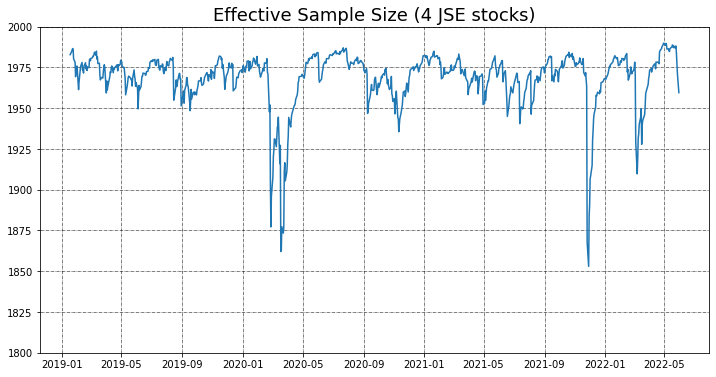

In [8]:
import matplotlib.pyplot as plt
new_data_frame = pd.DataFrame(data["MTN.JO"][1300:2140])   
new_data_frame["ESS"] = (ESS_list)                
ESS_values = new_data_frame
plt.figure(figsize = (12, 6))
plt.plot(ESS_values['ESS'])     
plt.ylim([700, 1000])

plt.title('Effective Sample Size (4 JSE stocks)', fontsize = 18)

plt.grid(color = 'black', linestyle = '-.', linewidth = 0.5)

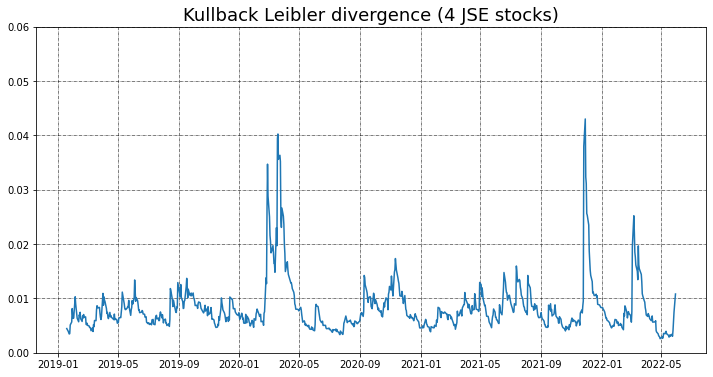

In [10]:
import matplotlib.pyplot as plt
new_data_frame = pd.DataFrame(data["MTN.JO"][1300:2140])   
new_data_frame["HN"] = (HN_list)                
HN_values = new_data_frame
plt.figure(figsize = (12, 6))
plt.plot(HN_values['HN'])    
plt.ylim([0, 0.06])

plt.title('Kullback Leibler divergence (4 JSE stocks)', fontsize = 18)
plt.grid(color = 'black', linestyle = '-.', linewidth = 0.5)

In [14]:
T = len(time_length_1) + len(time_length_2)
all_time_forecasts = [all_time_forecasts[i].flatten() for i in range(0, len(all_time_forecasts))]
for ticker in tickers: 
    print( " ")
    index = tickers.index(ticker)
    e_array = np.array([ ])
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        e = data[ticker][T+i] - forecast
        e_array = np.append(e_array, e)
    #print(e_array)
    RMSE = ( sum(e_array**2) / len(all_time_forecasts) )**0.5
    MAD = sum(np.absolute(e_array)) / len(all_time_forecasts)
    print('For' ,ticker,', RMSE = ', RMSE)
    print('For' ,ticker,', MAD = ', MAD)

 
For JSE.JO , RMSE =  0.017433394241520007
For JSE.JO , MAD =  0.01237909623429705
 
For ABG.JO , RMSE =  0.02677735519078999
For ABG.JO , MAD =  0.01864327841929701
 
For MTN.JO , RMSE =  0.03168842782601199
For MTN.JO , MAD =  0.02040700279349956
 
For SBK.JO , RMSE =  0.023752991869750648
For SBK.JO , MAD =  0.016645459547797843


In [ ]:
%%time 
from scipy import special
from scipy.optimize import fsolve

beta =  0.95 #ave_beta
delta_phi = 0.98 #ave_delta_phi                                     
delta_gamma = 0.96 # ave_delta_gamma

time_length_3 = range(848, 851)

ESS_list = []
HN_list = []

all_time_forecasts = []
all_time_var = []
for t in time_length_3:
 
    n_list = []
    sp_set_list = []
    all_sp_sets_IS = []
    all_lamda_IS_lists = []
    all_theta_IS_lists = []
    mu_list = []
    Lamda_list = []
    forecasts_list = []
    var_list = []
        
    for ticker in tickers:
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                          
        a = a_list[index]                       
        R = R_list[index]   # priors for individual stocks, picked from phase 2
        r = r_list[index]
        c = c_list[index]
            
        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            
        F_list = [1] 
        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns 
        for k in range((number_of_sp-1), -1, -1):   # generate F vector by adding values of simultaneous parents
            data_point = data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
            F_list.append(data_point)
        F = np.array([[i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks 
        
        sp_set = data.iloc[[t]].values.tolist()[0] # returns for all stocks at time t
            
        for i in range(0, len(sp_set)):
            for k in range(1, (number_of_sp + 1)):  # formation of a row of the gamma matrix 
                if sp_set[i] == F[k][0]:
                    sp_set[i] = a[k][0]
        for i in range(0, len(sp_set)):
            u = 0
            for k in range(1, (number_of_sp + 1)):
                if sp_set[i] == a[k][0]:
                    u = u + 1
            if u == 0:
                sp_set[i] = 0
        sp_set_list.append(sp_set) 
        
        mu_list.append(a[0][0])    # To be used to form the column vector mu_t
        Lamda_list.append(1/c)     # To be used to form Lambda matrix 
        
        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c        
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]
            
        lamda_IS_list = []
        theta_IS_list = []
        single_ticker_sp_sets_IS = []
        
        for i in range(0, N):
            
            shape = n/2
            scale = 2/(n*s)
            lamda_IS = np.random.gamma(shape, scale) # simulation of precision lambda 
            lamda_IS_list.append(lamda_IS)
                    
            m = m.flatten()                  # simulation of state vector theta given precision lambda                                                                                                                                                                            
            theta_IS = np.random.multivariate_normal(m, C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))
            
            data_sp_IS = data.drop([ticker], axis = 1)
            tickers.remove(ticker)
            data_point_list = [np.nan]        # values of simultaneous parents kept here  
            for k in range((number_of_sp-1), -1, -1):  
                data_point_IS = data_sp_IS[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
                data_point_list.append(data_point_IS) 
            all_stocks.insert(index, ticker)
            
            sp_set_IS = data.iloc[[t]].values.tolist()[0]          # returns for all stocks at time t
                
            for i in range(0, len(sp_set_IS)):
                for k in range(1, (number_of_sp+1)):  # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == data_point_list[k]:
                        sp_set_IS[i] = theta_IS[k]               
            for i in range(0, len(sp_set_IS)):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)
            
        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
        all_lamda_IS_lists.append(lamda_IS_list)
        all_theta_IS_lists.append(theta_IS_list)
    
    IS_weight_array = np.array([])
    for T in range(0, N):       # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [] 
        for j in range(0, len(tickers)):                                                                                                                                                                                                                                                                                                                                                                  
            Gamma_row  = all_sp_sets_IS[j][T]   
            Gamma_rows.append(Gamma_row)    
            Gamma_IS = np.array(Gamma_rows)                  # Gamma_t is the gamma matrix in the IS 
        matrix_IS_weight = np.identity(len(tickers)) - Gamma_IS  
        IS_weight = np.absolute(np.linalg.det(matrix_IS_weight))    # IS weights 
        IS_weight_array = np.append(IS_weight_array, IS_weight)   
    alpha = (1/sum(IS_weight_array))*IS_weight_array      # normalised IS weights (alpha)
    
    ESS = 1/sum(alpha**2)                     # effective sample size 
    ESS_list.append(ESS)
    #print('ESS = ', ESS)
        
    entropy_list = []          # calculation of entropy 
    for i in range(0, N):
        entropy = alpha[i]*np.log(N*alpha[i])
        entropy_list.append(entropy)
    HN =  sum(entropy_list)
    HN_list.append(HN)
    #print("HN = ", HN)
    
    
     # JOINT FORECASTING  
    Gamma_t = np.array(sp_set_list)    # Gamma_t matrix for forecasting 
    mu_t = np.array([[i] for i in mu_list])      # formation of mean vector for the joint forecasts
    A_tmu_t = np.linalg.pinv( np.identity(len(tickers)) - Gamma_t) @ mu_t  
    A_tmu_t = A_tmu_t.flatten()
        
    Lamda_t =  np.diag(Lamda_list)  # formation of the forecast covariance matrix 
    Sigma_t = np.linalg.pinv( (np.identity(len(tickers)) - Gamma_t).transpose() @ Lamda_t @            
                              (np.identity(len(tickers)) - Gamma_t) )
                                                                  
    forecasts = sum((np.random.multivariate_normal(A_tmu_t, Sigma_t, K, check_valid = 'warn')))/K # joint forecasts 

    forecasts_list.append(forecasts) # append forecasts for all stocks at time t to a list 
    
    var_list.append(np.diag(Sigma_t))  # append variances corresponding to all point forecasts at time t to a list
    
    n_list_2 = []
    a_temp_list = []
    R_temp_list = []
    r_temp_list = []
    c_temp_list = []
                                  # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock
        
        m_num_list = []
        m_den_list = []
        for i in range(0, N):         # Calculation of m from the VB formula 
            lamda_VB = lamda_IS_list[i]  
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            m_num = alpha_VB*lamda_VB*theta_VB
            m_num_list.append(m_num)
            
            m_den = alpha_VB*lamda_VB
            m_den_list.append(m_den)
        m = sum(m_num_list)/sum(m_den_list)
        
        summand_list = []
        for i in range(0, N):                         # calculation of V using the VB formula 
            lamda_VB = lamda_IS_list[i]
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            summand = alpha_VB * lamda_VB * (theta_VB - m) @ (theta_VB - m).transpose()
            summand_list.append(summand)
        V = sum(summand_list)
        
        summand_list = []
        for i in range(0, N):             # calculation of d as in the VB formula 
            lamda_VB = lamda_IS_list[i]
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            summand = alpha_VB*lamda_VB*((theta_VB - m).transpose() @ np.linalg.pinv(V) @ (theta_VB - m)) 
            summand_list.append(summand)
        d = sum(summand_list)
        d = d[0]; d = d[0]
        
        p_j = len(theta_IS)           # size of state vector in phases 2 and 3
        
            
        summand_1_list = []
        summand_2_list = []
        n_initial = n_list[index]
        for i in range(0, N):
            alpha_VB = alpha[i]
            lamda_VB = lamda_IS_list[i]             # solving for n under VB
                
            summand_1 = alpha_VB * lamda_VB
            summand_1_list.append(summand_1)
            
            summand_2 = alpha_VB * np.log(lamda_VB)
            summand_2_list.append(summand_2)
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                             np.log(abs( 2 * sum(summand_1_list))) + sum(summand_2_list))
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)
        
        summand_list = []
        for i in range(0, N):       # Calculation of s
            alpha_VB = alpha[i]
            lamda_VB = lamda_IS_list[i] 
            
            summand = alpha_VB * lamda_VB
            summand_list.append(summand) 
        s = (n + p_j - d)/(n*sum(summand_list)) 
        
        C = s*V                     # Calculation of C
            
        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)
    
    all_time_forecasts.append(forecasts_list[0])
    all_time_var.append(var_list[0])
    a_list = a_temp_list                     # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list
 

In [86]:
%%time 
import math
from scipy import special 
from scipy.optimize import fsolve
from scipy.stats import multivariate_t

df_range = np.linspace(0.99, 0.999, num = 1)                       # interval over which beta is chosen 

LLH_all_t_df_list = []
for delta_phi in df_range:
    
    beta, delta_gamma, time_length_2, M = 0.96, 0.98, range(845, 865), len(tickers)
    
    r_list, c_list, a, R_values, diag_element =  [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01
    
    r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
    c_list.extend(c_list*(M-1))
    
    a = np.array([[i] for i in a])
    a_list = [a]
    a_list.extend(a_list*(M-1))
    
    R_values.extend([diag_element]*number_of_sp)
    R = np.diag(R_values)
    R_list = [R]
    R_list.extend(R_list*(M-1))
    
    LLH_all_t_list = []
    for t in time_length_2:

        n_list = []
        sp_set_list = []
        all_sp_sets_IS = []
        all_lamda_IS_lists = []
        all_theta_IS_lists = []
        mu_list = []
        Lamda_list = []
        r_LLH_list = []
        
        for ticker in tickers:
            
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
            
            a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

            r_LLH_list.append(r) # keep a list of r values to be used to calculate loglikelihood
            
            gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            
            data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
            tickers.remove(ticker)                          # remove its symbol from the columns       
            F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                      for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
            F_list = [1] + F_list
            F = np.array([ [i] for i in F_list])
            all_stocks.insert(index, ticker)                    # get back full list of stocks            
            
            sp_set = data.iloc[[t]].values.tolist()[0] # generates list with all returns for all stocks at time t
            
            for i in range(0, M):
                for k in range(1, (number_of_sp + 1)):  # formation of a row of the gamma matrix 
                    if sp_set[i] == F[k][0]:
                        sp_set[i] = a[k][0]
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp + 1)):
                    if sp_set[i] == a[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set[i] = 0
            sp_set_list.append(sp_set)
            
            mu_list.append(a[0][0])    # To be used to form the column vector mu_t
            Lamda_list.append(1/c)     # To be used to form Lambda matrix 
    
            f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
            q = F.transpose() @ R @ F + c        
            e = data[ticker][t] - f 
            A = (R @ F)/q
            z = (r + (e**2)/q)/(r+1)
            m = a +A*e
            C = (R-(A @ A.transpose())*q)*z
            n = r + 1
            n_list.append(n)
            s = z*c; s = s[0][0]
            
            lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
            
            theta_IS_list = multivariate_t.rvs(m.flatten(), C, df = n, size = N)           # simulation of state for IS
            theta_IS_list = [theta_IS_list[i].reshape(-1, 1) for i in range(0, len(theta_IS_list))]
            
            data_sp_IS = data.drop([ticker], axis = 1)
            tickers.remove(ticker)
            data_point_list = [data_sp_IS[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
                               for k in range((number_of_sp-1), -1, -1)] 
            data_point_list = [np.nan] +  data_point_list                   # values of simultaneous parents kept here 
            all_stocks.insert(index, ticker)          
                                                   # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
            single_ticker_sp_sets_IS = []  
            for i in range(0, N): 
                
                sp_set_IS = data.iloc[[t]].values.tolist()[0]          # returns for all stocks at time t
                theta_IS = theta_IS_list[i]
                for i in range(0, M):
                    for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                        if sp_set_IS[i] == data_point_list[k]:
                            sp_set_IS[i] = theta_IS[k][0]               
                for i in range(0, M):
                    u = 0
                    for k in range(1, (number_of_sp+1)): 
                        if sp_set_IS[i] == theta_IS[k][0]:
                            u = u + 1
                    if u == 0:
                        sp_set_IS[i] = 0
                single_ticker_sp_sets_IS.append(sp_set_IS)
                            
            all_sp_sets_IS.append(single_ticker_sp_sets_IS)
            all_lamda_IS_lists.append(lamda_IS_list)
            all_theta_IS_lists.append(theta_IS_list)
            
        IS_weight_list = []
        for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
            Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
            Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
            IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
            IS_weight_list.append(IS_weight)
            IS_weight_array = np.array(IS_weight_list)
        alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
            
            # JOINT FORECASTING  
        Gamma_t = np.array(sp_set_list)    # Gamma_t matrix for forecasting 
        mu_t = np.array([[i] for i in mu_list])      # formation of mean vector for the joint forecasts
        A_tmu_t = np.linalg.pinv( np.identity(M) - Gamma_t) @ mu_t  
        A_tmu_t = A_tmu_t.flatten()
        
        Lamda_t =  np.diag(Lamda_list)  # formation of the forecast covariance matrix 
        Sigma_t = np.linalg.pinv( (np.identity(M) - Gamma_t).transpose() @ Lamda_t @ (np.identity(M) - Gamma_t) )
         
        forecasts = A_tmu_t    
        #forecasts = sum((np.random.multivariate_normal(A_tmu_t, Sigma_t, K, check_valid = 'warn')))/K #joint forecasting 
        
        var_array = np.diag(Sigma_t)     # variance corresponding to individual/point forecasts 
        
        LLH_t_list = []
        for ticker in tickers: 
            index = tickers.index(ticker)              
            e = data[ticker][t] - forecasts[index]  # get forecast error, degrees of freedom and scale for each stock 
            deg_fre = r_LLH_list[index]
            scale_value = var_array[index]
            
            # predictive distribution density used to set up loglikelihood 
            part_1 = np.log(math.gamma((deg_fre+1)/2) / (math.gamma(deg_fre/2)*math.sqrt(deg_fre*math.pi*scale_value)))
            part_2 =  ((deg_fre + 1) /2) * np.log( 1 + (e**2)/(deg_fre*scale_value))
            LLH_t  = part_1 - part_2        # loglikelihood at time t for each stock 
            LLH_t_list.append(LLH_t)
        
        LLH_all_t_list.append(LLH_t_list)
            
        n_list_2 = []
        a_temp_list = []
        R_temp_list = []
        r_temp_list = []
        c_temp_list = []
                              # VB starts here 
        for ticker in tickers: 
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
            lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
            theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

            m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
            m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
            m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 
            
                         
            V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                     for i in range(0, N) ])   # calculation of V using the VB formula 
           
            d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                    (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d
            
            p_j = len(theta_IS)           # size of state vector in phases 2 and 3 
    
            n_initial = n_list[index]          # calculation of n 
            sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
            sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
            func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                              np.log(abs( 2 * sum_1)) + sum_2)
            n =  fsolve(func, [n_initial])[0]
            n_list_2.append(n)
            
            sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
            s =(n + p_j - d)/(n*sum_in_s) 
    
            C = s*V                     # Calculation of C
            
            a =  m                          # kalman filter equations, evolution to the next day 
            a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
            block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
            block_2 = C[1:, 1:] * (1/delta_gamma-1)
            W  = block_diag(block_1, block_2)

            R = C + W
            R_temp_list.append(R) 
            r = beta*n
            r_temp_list.append(r)
            c = s
            c_temp_list.append(c)
                      
        a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
        R_list = R_temp_list
        r_list = r_temp_list
        c_list = c_temp_list
    LLH_all_t_df_list.append(LLH_all_t_list)

all_LLH = []                       # LLH_all_t_df_list is a list of lists of LLH values of all stocks for
for i in LLH_all_t_df_list:          # different discount factors at different times 
    LLH_each_df = []                
    for ticker in tickers:             # We want to sum up (independently) LLH values for each stock for the
        index = tickers.index(ticker)    #  entire period of time for every discount factor
        LLH_list = []
        for k in i:
            LLH_t = k[index]
            LLH_list.append(LLH_t)
        LLH = sum(LLH_list)
        LLH_each_df.append(LLH)
    all_LLH.append(LLH_each_df)  # all_LLH is the list with loglikelihood for each stock at different discount factors

df_value_list = []
for ticker in tickers: 
    index = tickers.index(ticker)
    single_stock_LLH_list = []
    for k in all_LLH:
        LLH = k[index]
        single_stock_LLH_list.append(LLH)
    df_value = df_range[np.argmax(single_stock_LLH_list)]
    df_value_list.append(df_value)
print('delta_phi values =', df_value_list)
ave_delta_phi =  sum(df_value_list)/M
print('Average value of delta_phi is ', round(ave_delta_phi, 4))


delta_phi values = [0.99, 0.99, 0.99, 0.99]
Average value of delta_phi is  0.99
CPU times: total: 30 s
Wall time: 30.1 s


In [118]:
%%time 
import math
from scipy import special 
from scipy.optimize import fsolve

df_range = np.linspace(0.99, 0.999, num = 1)                       # interval over which beta is chosen 

LLH_all_t_df_list = []
for delta_phi in df_range:
    
    beta = 0.96
    delta_gamma = 0.98
    time_length_2 = range(845, 865)
    
    r_list =  [5]
    r_list.extend(r_list*(len(tickers)-1))          # Initial information at prior stage: a, R, r, c
                  
    c_list =  [0.001]
    c_list.extend(c_list*(len(tickers)-1))
    
    a = np.zeros((number_of_sp+1), dtype = int )
    a = np.array([[i] for i in a])
    a_list = [a]
    a_list.extend(a_list*(len(tickers)-1))
    
    R_values = [0.0001]
    diag_element = 0.01
    R_values.extend([diag_element]*number_of_sp)
    R = np.diag(R_values)
    R_list = [R]
    R_list.extend(R_list*(len(tickers)-1))
    
    LLH_all_t_list = []
    for t in time_length_2:

        n_list = []
        sp_set_list = []
        all_sp_sets_IS = []
        all_lamda_IS_lists = []
        all_theta_IS_lists = []
        mu_list = []
        Lamda_list = []
        r_LLH_list = []
        
        for ticker in tickers:
            
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                          
            a = a_list[index]                                   # priors for individual stocks   
            R = R_list[index]
            r = r_list[index]
            c = c_list[index]
            
            r_LLH_list.append(r) # keep a list of r values to be used to calculate loglikelihood
            
            gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            
            F_list = [1] 
            data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
            tickers.remove(ticker)                          # remove its symbol from the columns 
            for k in range((number_of_sp-1), -1, -1):   # generate F vector by adding values of simultaneous parents
                data_point = data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
                F_list.append(data_point)
            F = np.array([[i] for i in F_list])
            all_stocks.insert(index, ticker)                    # get back full list of stocks            
            
            sp_set = data.iloc[[t]].values.tolist()[0] # returns for all stocks at time t
            
            for i in range(0, len(sp_set)):
                for k in range(1, (number_of_sp + 1)):  # formation of a row of the gamma matrix 
                    if sp_set[i] == F[k][0]:
                        sp_set[i] = a[k][0]
            for i in range(0, len(sp_set)):
                u = 0
                for k in range(1, (number_of_sp + 1)):
                    if sp_set[i] == a[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set[i] = 0
            sp_set_list.append(sp_set)
            
            mu_list.append(a[0][0])    # To be used to form the column vector mu_t
            Lamda_list.append(1/c)     # To be used to form Lambda matrix 
    
            f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
            q = F.transpose() @ R @ F + c        
            e = data[ticker][t] - f 
            A = (R @ F)/q
            z = (r + (e**2)/q)/(r+1)
            m = a +A*e
            C = (R-(A @ A.transpose())*q)*z
            n = r + 1
            n_list.append(n)
            s = z*c; s = s[0][0]
            
            lamda_IS_list = []
            theta_IS_list = []
            single_ticker_sp_sets_IS = []
        
                                  # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
            for i in range(0, N):
                
                shape = n/2
                scale = 2/(n*s)
                lamda_IS = np.random.gamma(shape, scale) # simulation of precision lambda 
                lamda_IS_list.append(lamda_IS)
                    
                m = m.flatten()                  # simulation of state vector theta given precision lambda                                                                                                                                                                            
                theta_IS = np.random.multivariate_normal(m, C/(s*lamda_IS_list[i]), check_valid = 'warn')
                theta_IS_list.append(theta_IS.reshape(-1, 1))
               
                data_sp_IS = data.drop([ticker], axis = 1)
                tickers.remove(ticker)
                data_point_list = [np.nan]        # values of simultaneous parents kept here  
                for k in range((number_of_sp-1), -1, -1):  
                    data_point_IS = data_sp_IS[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
                    data_point_list.append(data_point_IS) 
                all_stocks.insert(index, ticker)          
                
                sp_set_IS = data.iloc[[t]].values.tolist()[0]          # returns for all stocks at time t
                
                for i in range(0, len(sp_set_IS)):
                    for k in range(1, (number_of_sp+1)):  # formation of a row of the gamma matrix 
                        if sp_set_IS[i] == data_point_list[k]:
                            sp_set_IS[i] = theta_IS[k]               
                for i in range(0, len(sp_set_IS)):
                    u = 0
                    for k in range(1, (number_of_sp+1)): 
                        if sp_set_IS[i] == theta_IS[k]:
                            u = u + 1
                    if u == 0:
                        sp_set_IS[i] = 0
                single_ticker_sp_sets_IS.append(sp_set_IS)
                            
            all_sp_sets_IS.append(single_ticker_sp_sets_IS)
            all_lamda_IS_lists.append(lamda_IS_list)
            all_theta_IS_lists.append(theta_IS_list)
            
        IS_weight_array = np.array([])
        for T in range(0, N):       # formation of the Gamma_t matrix in the IS     
            Gamma_rows = [] 
            for j in range(0, len(tickers)):                                                                                                                                                                                                                                                                                                                                                                  
                Gamma_row  = all_sp_sets_IS[j][T]   
                Gamma_rows.append(Gamma_row)    
                Gamma_IS = np.array(Gamma_rows)                  # Gamma_IS is the gamma matrix in the IS
            matrix_IS_weight = np.identity(len(tickers)) - Gamma_IS  
            IS_weight = np.absolute(np.linalg.det(matrix_IS_weight))    # IS weights 
            IS_weight_array = np.append(IS_weight_array, IS_weight)   
        alpha = (1/sum(IS_weight_array))*IS_weight_array      # normalised IS weights (alpha)
             
            # JOINT FORECASTING  
        Gamma_t = np.array(sp_set_list)    # Gamma_t matrix for forecasting 
        mu_t = np.array([[i] for i in mu_list])      # formation of mean vector for the joint forecasts
        A_tmu_t = np.linalg.pinv( np.identity(len(tickers)) - Gamma_t) @ mu_t  
        A_tmu_t = A_tmu_t.flatten()
        
        Lamda_t =  np.diag(Lamda_list)  # formation of the forecast covariance matrix 
        Sigma_t = np.linalg.pinv( (np.identity(len(tickers)) - Gamma_t).transpose() @ Lamda_t @            
                              (np.identity(len(tickers)) - Gamma_t) )
                                                                  
        forecasts = sum((np.random.multivariate_normal(A_tmu_t, Sigma_t, K, check_valid = 'warn')))/K #joint forecasting 
        
        var_array = np.diag(Sigma_t)     # variance corresponding to individual/point forecasts 
        
        LLH_t_list = []
        for ticker in tickers: 
            index = tickers.index(ticker)              
            e = data[ticker][t] - forecasts[index]  # get forecast error, degrees of freedom and scale for each stock 
            deg_fre = r_LLH_list[index]
            scale_value = var_array[index]
            
            # predictive distribution density used to set up loglikelihood 
            part_1 = np.log(math.gamma((deg_fre+1)/2) / (math.gamma(deg_fre/2)*math.sqrt(deg_fre*math.pi*scale_value)))
            part_2 =  ((deg_fre + 1) /2) * np.log( 1 + (e**2)/(deg_fre*scale_value))
            LLH_t  = part_1 - part_2        # loglikelihood at time t for each stock 
            LLH_t_list.append(LLH_t)
        
        LLH_all_t_list.append(LLH_t_list)
            
        n_list_2 = []
        a_temp_list = []
        R_temp_list = []
        r_temp_list = []
        c_temp_list = []
                              # VB starts here 
        for ticker in tickers: 
            index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
            lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
            theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock
            
            m_num_list = []
            m_den_list = []
            for i in range(0, N):         # Calculation of m from the VB formula 
                lamda_VB = lamda_IS_list[i]  
                theta_VB = theta_IS_list[i]
                alpha_VB = alpha[i]
            
                m_num = alpha_VB*lamda_VB*theta_VB
                m_num_list.append(m_num)
            
                m_den = alpha_VB*lamda_VB
                m_den_list.append(m_den)
            m = sum(m_num_list)/sum(m_den_list)
            
            summand_list = []
            for i in range(0, N):                         # calculation of V using the VB formula 
                lamda_VB = lamda_IS_list[i]
                theta_VB = theta_IS_list[i]
                alpha_VB = alpha[i]
            
                summand = alpha_VB * lamda_VB * (theta_VB - m) @ (theta_VB - m).transpose()
                summand_list.append(summand)
            V = sum(summand_list) 
           
            summand_list = []
            for i in range(0, N):             # calculation of d as in the VB formula 
                lamda_VB = lamda_IS_list[i]
                theta_VB = theta_IS_list[i]
                alpha_VB = alpha[i]
            
                summand = alpha_VB*lamda_VB*((theta_VB - m).transpose() @ np.linalg.pinv(V) @ (theta_VB - m)) 
                summand_list.append(summand)
            d = sum(summand_list)
            d = d[0]; d = d[0]
            
            p_j = len(theta_IS)           # size of state vector in phases 2 and 3 
    
            summand_1_list = []
            summand_2_list = []
            n_initial = n_list[index]
            for i in range(0, N):
                alpha_VB = alpha[i]
                lamda_VB = lamda_IS_list[i]             # solving for n under VB
                
                summand_1 = alpha_VB * lamda_VB
                summand_1_list.append(summand_1)
            
                summand_2 = alpha_VB * np.log(lamda_VB)
                summand_2_list.append(summand_2)
            func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                             np.log(abs( 2 * sum(summand_1_list))) + sum(summand_2_list))
            n =  fsolve(func, [n_initial])[0]
            n_list_2.append(n)
            
            summand_list = []
            for i in range(0, N):       # Calculation of s
                alpha_VB = alpha[i]
                lamda_VB = lamda_IS_list[i] 
            
                summand = alpha_VB * lamda_VB
                summand_list.append(summand) 
            s = (n + p_j - d)/(n*sum(summand_list))  
    
            C = s*V                     # Calculation of C
            
            a =  m                          # kalman filter equations, evolution to the next day 
            a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
            block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
            block_2 = C[1:, 1:] * (1/delta_gamma-1)
            W  = block_diag(block_1, block_2)

            R = C + W
            R_temp_list.append(R) 
            r = beta*n
            r_temp_list.append(r)
            c = s
            c_temp_list.append(c)
                      
        a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
        R_list = R_temp_list
        r_list = r_temp_list
        c_list = c_temp_list
    LLH_all_t_df_list.append(LLH_all_t_list)

all_LLH = []                       # LLH_all_t_df_list is a list of lists of LLH values of all stocks for
for i in LLH_all_t_df_list:          # different discount factors at different times 
    LLH_each_df = []                
    for ticker in tickers:             # We want to sum up (independently) LLH values for each stock for the
        index = tickers.index(ticker)    #  entire period of time for every discount factor
        LLH_list = []
        for k in i:
            LLH_t = k[index]
            LLH_list.append(LLH_t)
        LLH = sum(LLH_list)
        LLH_each_df.append(LLH)
    all_LLH.append(LLH_each_df)  # all_LLH is the list with loglikelihood for each stock at different discount factors

df_value_list = []
for ticker in tickers: 
    index = tickers.index(ticker)
    single_stock_LLH_list = []
    for k in all_LLH:
        LLH = k[index]
        single_stock_LLH_list.append(LLH)
    df_value = df_range[np.argmax(single_stock_LLH_list)]
    df_value_list.append(df_value)
print('delta_phi values =', df_value_list)
ave_delta_phi =  sum(df_value_list)/len(tickers)
print('Average value of delta_phi is ', round(ave_delta_phi, 4))

delta_phi values = [0.99, 0.99, 0.99, 0.99]
Average value of delta_phi is  0.99
CPU times: total: 2min 16s
Wall time: 2min 18s


In [65]:
%%time 
from scipy import special
from scipy.optimize import fsolve

beta =  0.95 #ave_beta
delta_phi = 0.98 #ave_delta_phi                                     
delta_gamma = 0.96 # ave_delta_gamma

time_length_3 = range(848, 851)

ESS_list = []
HN_list = []

all_time_forecasts = []
all_time_var = []
for t in time_length_3:
 
    n_list = []
    sp_set_list = []
    all_sp_sets_IS = []
    all_lamda_IS_lists = []
    all_theta_IS_lists = []
    mu_list = []
    Lamda_list = []
    forecasts_list = []
    var_list = []
        
    for ticker in tickers:
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                          
        a = a_list[index]                       
        R = R_list[index]   # priors for individual stocks, picked from phase 2
        r = r_list[index]
        c = c_list[index]
            
        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents
            
        F_list = [1] 
        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns 
        for k in range((number_of_sp-1), -1, -1):   # generate F vector by adding values of simultaneous parents
            data_point = data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
            F_list.append(data_point)
        F = np.array([[i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks 
        
        sp_set = data.iloc[[t]].values.tolist()[0] # returns for all stocks at time t
            
        for i in range(0, len(sp_set)):
            for k in range(1, (number_of_sp + 1)):  # formation of a row of the gamma matrix 
                if sp_set[i] == F[k][0]:
                    sp_set[i] = a[k][0]
        for i in range(0, len(sp_set)):
            u = 0
            for k in range(1, (number_of_sp + 1)):
                if sp_set[i] == a[k][0]:
                    u = u + 1
            if u == 0:
                sp_set[i] = 0
        sp_set_list.append(sp_set) 
        
        mu_list.append(a[0][0])    # To be used to form the column vector mu_t
        Lamda_list.append(1/c)     # To be used to form Lambda matrix 
        
        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c        
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]
            
        lamda_IS_list = []
        theta_IS_list = []
        single_ticker_sp_sets_IS = []
        
        for i in range(0, N):
            
            shape = n/2
            scale = 2/(n*s)
            lamda_IS = np.random.gamma(shape, scale) # simulation of precision lambda 
            lamda_IS_list.append(lamda_IS)
                    
            m = m.flatten()                  # simulation of state vector theta given precision lambda                                                                                                                                                                            
            theta_IS = np.random.multivariate_normal(m, C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))
            
            data_sp_IS = data.drop([ticker], axis = 1)
            tickers.remove(ticker)
            data_point_list = [np.nan]        # values of simultaneous parents kept here  
            for k in range((number_of_sp-1), -1, -1):  
                data_point_IS = data_sp_IS[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t]
                data_point_list.append(data_point_IS) 
            all_stocks.insert(index, ticker)
            
            sp_set_IS = data.iloc[[t]].values.tolist()[0]          # returns for all stocks at time t
                
            for i in range(0, len(sp_set_IS)):
                for k in range(1, (number_of_sp+1)):  # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == data_point_list[k]:
                        sp_set_IS[i] = theta_IS[k]               
            for i in range(0, len(sp_set_IS)):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)
            
        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
        all_lamda_IS_lists.append(lamda_IS_list)
        all_theta_IS_lists.append(theta_IS_list)
    
    IS_weight_array = np.array([])
    for T in range(0, N):       # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [] 
        for j in range(0, len(tickers)):                                                                                                                                                                                                                                                                                                                                                                  
            Gamma_row  = all_sp_sets_IS[j][T]   
            Gamma_rows.append(Gamma_row)    
            Gamma_IS = np.array(Gamma_rows)                  # Gamma_t is the gamma matrix in the IS 
        matrix_IS_weight = np.identity(len(tickers)) - Gamma_IS  
        IS_weight = np.absolute(np.linalg.det(matrix_IS_weight))    # IS weights 
        IS_weight_array = np.append(IS_weight_array, IS_weight)   
    alpha = (1/sum(IS_weight_array))*IS_weight_array      # normalised IS weights (alpha)
    
    ESS = 1/sum(alpha**2)                     # effective sample size 
    ESS_list.append(ESS)
    #print('ESS = ', ESS)
        
    entropy_list = []          # calculation of entropy 
    for i in range(0, N):
        entropy = alpha[i]*np.log(N*alpha[i])
        entropy_list.append(entropy)
    HN =  sum(entropy_list)
    HN_list.append(HN)
    #print("HN = ", HN)
    
    
     # JOINT FORECASTING  
    Gamma_t = np.array(sp_set_list)    # Gamma_t matrix for forecasting 
    mu_t = np.array([[i] for i in mu_list])      # formation of mean vector for the joint forecasts
    A_tmu_t = np.linalg.pinv( np.identity(len(tickers)) - Gamma_t) @ mu_t  
    A_tmu_t = A_tmu_t.flatten()
        
    Lamda_t =  np.diag(Lamda_list)  # formation of the forecast covariance matrix 
    Sigma_t = np.linalg.pinv( (np.identity(len(tickers)) - Gamma_t).transpose() @ Lamda_t @            
                              (np.identity(len(tickers)) - Gamma_t) )
                                                                  
    forecasts = sum((np.random.multivariate_normal(A_tmu_t, Sigma_t, K, check_valid = 'warn')))/K # joint forecasts 

    forecasts_list.append(forecasts) # append forecasts for all stocks at time t to a list 
    
    var_list.append(np.diag(Sigma_t))  # append variances corresponding to all point forecasts at time t to a list
    
    n_list_2 = []
    a_temp_list = []
    R_temp_list = []
    r_temp_list = []
    c_temp_list = []
                                  # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock
        
        m_num_list = []
        m_den_list = []
        for i in range(0, N):         # Calculation of m from the VB formula 
            lamda_VB = lamda_IS_list[i]  
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            m_num = alpha_VB*lamda_VB*theta_VB
            m_num_list.append(m_num)
            
            m_den = alpha_VB*lamda_VB
            m_den_list.append(m_den)
        m = sum(m_num_list)/sum(m_den_list)
        
        summand_list = []
        for i in range(0, N):                         # calculation of V using the VB formula 
            lamda_VB = lamda_IS_list[i]
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            summand = alpha_VB * lamda_VB * (theta_VB - m) @ (theta_VB - m).transpose()
            summand_list.append(summand)
        V = sum(summand_list)
        
        summand_list = []
        for i in range(0, N):             # calculation of d as in the VB formula 
            lamda_VB = lamda_IS_list[i]
            theta_VB = theta_IS_list[i]
            alpha_VB = alpha[i]
            
            summand = alpha_VB*lamda_VB*((theta_VB - m).transpose() @ np.linalg.pinv(V) @ (theta_VB - m)) 
            summand_list.append(summand)
        d = sum(summand_list)
        d = d[0]; d = d[0]
        
        p_j = len(theta_IS)           # size of state vector in phases 2 and 3
        
            
        summand_1_list = []
        summand_2_list = []
        n_initial = n_list[index]
        for i in range(0, N):
            alpha_VB = alpha[i]
            lamda_VB = lamda_IS_list[i]             # solving for n under VB
                
            summand_1 = alpha_VB * lamda_VB
            summand_1_list.append(summand_1)
            
            summand_2 = alpha_VB * np.log(lamda_VB)
            summand_2_list.append(summand_2)
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                             np.log(abs( 2 * sum(summand_1_list))) + sum(summand_2_list))
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)
        
        summand_list = []
        for i in range(0, N):       # Calculation of s
            alpha_VB = alpha[i]
            lamda_VB = lamda_IS_list[i] 
            
            summand = alpha_VB * lamda_VB
            summand_list.append(summand) 
        s = (n + p_j - d)/(n*sum(summand_list)) 
        
        C = s*V                     # Calculation of C
            
        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp
            
        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)
    
    all_time_forecasts.append(forecasts_list[0])
    all_time_var.append(var_list[0])
    a_list = a_temp_list                     # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list
 

CPU times: total: 62.5 ms
Wall time: 251 ms


In [86]:
T = len(time_length_1) + len(time_length_2)
for ticker in tickers: 
    print( " ")
    index = tickers.index(ticker)
    e_array = np.array([ ])
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        e = data[ticker][T+i] - forecast
        e_array = np.append(e_array, e)
    print(e_array)
    RMSE = math.sqrt( sum(e_array**2) / len(all_time_forecasts) )
    MAD = sum(np.absolute(e_array)) / len(all_time_forecasts)
    print('For' ,ticker,', RMSE = ', RMSE)
    print('For' ,ticker,', MAD = ', MAD)

 
[-0.00479594  0.00545382  0.00045711]
For JSE.JO , RMSE =  0.004201352840733593
For JSE.JO , MAD =  0.0035689561407168213
 
[-0.022992    0.00776583 -0.02505095]
For ABG.JO , RMSE =  0.0201369481509137
For ABG.JO , MAD =  0.018602924042373042
 
[-0.02770898  0.01855183  0.02528136]
For MTN.JO , RMSE =  0.02415991841739765
For MTN.JO , MAD =  0.023847388729479974
 
[-0.00795903  0.00361625  0.02625766]
For SBK.JO , RMSE =  0.015977989921374076
For SBK.JO , MAD =  0.012610984536843286


In [55]:
T = len(time_length_1) + len(time_length_2)
all_ticker_interval_values = []
for ticker in tickers: 
    print( " ")
    index = tickers.index(ticker)
    ticker_interval_values = []
    
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        var = all_time_var[i][index]
        
        interval = 0.67*math.sqrt(var)*math.sqrt(1 + 1/K)
        lower = forecast - interval 
        upper = forecast + interval
        if data[ticker][T+i] >= lower and data[ticker][T+i] <= upper:    
            ticker_interval_values.append(data[ticker][T+i])
            all_ticker_interval_values.append(data[ticker][T+i])
    ticker_interval_coverage =  len(ticker_interval_values)/(len(all_time_forecasts))*100    
    print('Interval coverage for', ticker,  'is ', round(ticker_interval_coverage, 1),'%') 
    
total_interval_coverage = len(all_ticker_interval_values)/(len(all_time_forecasts)*len(tickers))*100                 
                                                                                                       
print(' ')                                                                                                                                                                                              
print('Interval coverage in the aggregate is ', round(total_interval_coverage, 1),'%')       

 
Interval coverage for JSE.JO is  100.0 %
 
Interval coverage for ABG.JO is  60.0 %
 
Interval coverage for MTN.JO is  40.0 %
 
Interval coverage for SBK.JO is  70.0 %
 
Interval coverage in the aggregate is  67.5 %


In [2]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4]},
                       index = [pd.Timestamp('20130101 09:00:00'),
                                pd.Timestamp('20130101 09:00:02'),
                                pd.Timestamp('20130101 09:00:03'),
                                pd.Timestamp('20130101 09:00:05'),
                                pd.Timestamp('20130101 09:00:06')])
df

,B
2013-01-01 09:00:00,0
2013-01-01 09:00:02,1
2013-01-01 09:00:03,2
2013-01-01 09:00:05,3
2013-01-01 09:00:06,4


In [15]:
len(data)

2161

In [14]:
len(data[tickers[1]])

2161

In [17]:
moving_average = data[tickers[1]].rolling(50).mean()[1300:]
len(moving_average)

861